In [1]:
%pip install jupysql clickhouse_sqlalchemy matplotlib python-dotenv pandas seaborn imageio > /dev/null 2>&1

Note: you may need to restart the kernel to use updated packages.


In [2]:
import dotenv
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imageio

dotenv.load_dotenv()

True

In [3]:
def add_branding(fig, title=None, subtitle=None):
    # Get dimensions of input figure
    fig_width = fig.get_size_inches()[0]
    
    # Create header figure with fixed height (reduced to 25%)
    header_height = 1 # Was 2
    header_fig = plt.figure(figsize=(fig_width, header_height))
    
    # Add logos with increased size
    left_logo_ax = header_fig.add_axes([0.02, 0.2, 0.18, 0.7])  # Increased width and height
    right_logo_ax = header_fig.add_axes([0.82, 0.2, 0.16, 0.7]) # Increased width and height
    
    ethpandaops = plt.imread('../../assets/content/ethpandaops.png')
    xatu = plt.imread('../../assets/content/xatu.png')
    
    left_logo_ax.imshow(ethpandaops)
    right_logo_ax.imshow(xatu)
    
    left_logo_ax.axis('off')
    right_logo_ax.axis('off')
    
    # Add title and subtitle if provided
    if title:
        header_fig.text(0.5, 0.7, title, fontsize=20, fontweight='bold', ha='center')
    if subtitle:
        header_fig.text(0.5, 0.4, subtitle, fontsize=12, ha='center')
        
    # Stack figures
    combined_height = header_height + fig.get_size_inches()[1]
    combined_fig = plt.figure(figsize=(fig_width, combined_height))
    
    # Draw figures before accessing canvas
    header_fig.canvas.draw()
    fig.canvas.draw()
    
    # Copy contents using buffer_rgba instead of deprecated tostring_rgb
    header_img = np.frombuffer(header_fig.canvas.buffer_rgba(), dtype=np.uint8)
    header_img = header_img.reshape(header_fig.canvas.get_width_height()[::-1] + (4,))[:,:,:3]
    
    fig_img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    fig_img = fig_img.reshape(fig.canvas.get_width_height()[::-1] + (4,))[:,:,:3]
    
    # Add to combined figure with reduced padding
    # Move header down slightly to reduce space at top
    header_ax = combined_fig.add_axes([0, fig.get_size_inches()[1]/combined_height + 0.02, 1, (header_height-0.2)/combined_height])
    # Move content up to reduce gap between header and content
    content_ax = combined_fig.add_axes([0, 0.02, 1, (fig.get_size_inches()[1]-0.2)/combined_height])
    
    header_ax.imshow(header_img)
    content_ax.imshow(fig_img)
    
    header_ax.axis('off')
    content_ax.axis('off')
    
    plt.close(header_fig)
    plt.close(fig)
    
    return combined_fig

In [4]:
class Config:
    def __init__(self, time_ranges, network):
        self.time_ranges = time_ranges
        self.network = network


config = Config(
    [
        # ("2025-02-14T00:00:00Z", "2025-02-28T08:00:00Z"),
        # Skip holesky non-finalizing period
        ("2025-03-13T00:00:00Z", "2025-03-27T00:00:00Z")
    ],
    "holesky"
)

event_date = pd.to_datetime("2025-03-19T08:00:00Z", utc=True)

annotations = {
    "2025-03-19T08:00:00Z": "Prysm Block Publish Change",
}

# Convert annotation timestamps to datetime objects for later use
annotation_datetimes = {
    datetime.fromisoformat(ts.replace("Z", "+00:00")): msg
    for ts, msg in annotations.items()
}


In [5]:
# Connect to ClickHouse
import os
username = os.getenv('XATU_CLICKHOUSE_USERNAME')
password = os.getenv('XATU_CLICKHOUSE_PASSWORD')
host = os.getenv('XATU_CLICKHOUSE_HOST')


db_url = f"clickhouse+http://{username}:{password}@{host}:443/default?protocol=https"

from sqlalchemy import create_engine, text

engine = create_engine(db_url)

connection = engine.connect()

In [6]:
# Load known validators from the YAML file
import yaml
import os
from pathlib import Path

def load_validators(network):
    """Load validators from the YAML file for the specified network."""
    validators_path = Path(f"../../assets/ethereum/{network}/validators.yaml")
    
    if not validators_path.exists():
        print(f"Validators file not found at {validators_path}")
        return {}
    
    with open(validators_path, 'r') as file:
        validators_data = yaml.safe_load(file)
    
    # Process the validators data
    validators_map = {}
    for range_str, client in validators_data.items():
        if isinstance(range_str, str) and '-' in range_str:
            start, end = map(int, range_str.split('-'))
            for validator_index in range(start, end + 1):
                validators_map[validator_index] = client
        elif isinstance(range_str, int):
            # Handle single validator case
            validators_map[range_str] = client
    
    return validators_map

def get_validator_entity(validator_index, validators_map):
    """Get the entity/client associated with a validator index."""
    if validator_index in validators_map:
        return validators_map[validator_index]
    return "unknown"

def get_validator_entities(validator_indices, validators_map):
    """Get entities for multiple validator indices."""
    return {idx: get_validator_entity(idx, validators_map) for idx in validator_indices}

def is_validator_from_entity(validator_index, entity, validators_map):
    """Check if a validator belongs to a specific entity."""
    return get_validator_entity(validator_index, validators_map) == entity

# Load validators for the configured network
validators = load_validators(config.network)
print(f"Loaded {len(validators)} validators for {config.network}")


Loaded 1461002 validators for holesky


In [7]:
# Initialize empty DataFrames to store results from all time ranges
all_slots = pd.DataFrame()
block_availability = pd.DataFrame()
blob_availability = pd.DataFrame()

# Process each time range
for start_date, end_date in config.time_ranges:
    print(f"Processing time range: {start_date} to {end_date}")
    
    # Query for all slots in time window
    all_slots_query = text("""
        SELECT DISTINCT
            slot,
            slot_start_date_time as time
        FROM beacon_api_eth_v1_events_block 
        WHERE
            slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
            AND meta_network_name = :network
            AND slot > 200000 # Filter out incorrect data
        ORDER BY slot ASC
    """)

    result = connection.execute(all_slots_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', ''), "network": config.network})
    current_slots = pd.DataFrame(result.fetchall(), columns=['slot', 'time'])
    all_slots = pd.concat([all_slots, current_slots])

    # Query for block availability times by client
    block_availability_query = text("""
        SELECT
            slot,
            meta_client_name,
            MIN(propagation_slot_start_diff) as min_propagation_time
        FROM libp2p_gossipsub_beacon_block FINAL
        WHERE
            slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
            AND meta_network_name = :network
            AND propagation_slot_start_diff < 6000
            AND slot > 200000 # Filter out incorrect data
            AND meta_client_name != ''
            AND meta_client_name IS NOT NULL
        GROUP BY slot, meta_client_name
        ORDER BY slot ASC, meta_client_name ASC
    """)

    current_block_availability = pd.DataFrame(
        connection.execute(block_availability_query, {
            "start_date": start_date.replace('Z', ''), 
            "end_date": end_date.replace('Z', ''), 
            "network": config.network
        }).fetchall(),
        columns=['slot', 'meta_client_name', 'block_availability_time']
    )
    block_availability = pd.concat([block_availability, current_block_availability])

    # Query for blob availability times by client
    blob_availability_query = text("""
        SELECT
            slot,
            meta_client_name,
            blob_index,
            MIN(propagation_slot_start_diff) as min_propagation_time
        FROM libp2p_gossipsub_blob_sidecar FINAL
        WHERE
            slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
            AND meta_network_name = :network
            AND propagation_slot_start_diff < 6000
            AND slot > 200000 # Filter out incorrect data
            AND meta_client_name != ''
            AND meta_client_name IS NOT NULL
        GROUP BY slot, meta_client_name, blob_index
        ORDER BY slot ASC, meta_client_name ASC, blob_index ASC
    """)

    current_blob_availability = pd.DataFrame(
        connection.execute(blob_availability_query, {
            "start_date": start_date.replace('Z', ''), 
            "end_date": end_date.replace('Z', ''), 
            "network": config.network
        }).fetchall(),
        columns=['slot', 'meta_client_name', 'blob_index', 'blob_availability_time']
    )
    blob_availability = pd.concat([blob_availability, current_blob_availability])

print(f"Fetched {len(all_slots)} slots")
all_slots = all_slots.drop_duplicates()

print("Getting data availability times...")

# For each slot and client, calculate the data availability time
# This is the maximum of:
# 1. The block availability time
# 2. The availability time for each blob index
data_availability_by_client = []

# Group by slot and client
for (slot, client), group in pd.concat([
    block_availability[['slot', 'meta_client_name', 'block_availability_time']],
    blob_availability[['slot', 'meta_client_name', 'blob_index', 'blob_availability_time']]
]).groupby(['slot', 'meta_client_name']):
    
    # Get the block availability time
    block_time = group['block_availability_time'].min() if 'block_availability_time' in group else None
    
    # Get blob availability times for each blob index
    blob_times = {}
    if 'blob_availability_time' in group and 'blob_index' in group:
        for _, row in group[['blob_index', 'blob_availability_time']].dropna().iterrows():
            blob_times[row['blob_index']] = row['blob_availability_time']
    
    # Combine all times (block and all blobs)
    all_times = [block_time] if block_time is not None else []
    all_times.extend(blob_times.values())
    
    # Calculate data availability time as the maximum of all times
    data_availability_time = max(all_times) if all_times else None
    
    data_availability_by_client.append({
        'slot': slot,
        'meta_client_name': client,
        'block_availability_time': block_time,
        'blob_times': blob_times,
        'data_availability_time': data_availability_time
    })

data_availability_by_client_df = pd.DataFrame(data_availability_by_client)

# Calculate min, p05, p50, p95, and max data availability times per slot
data_availability_agg = data_availability_by_client_df.groupby('slot').agg({
    'data_availability_time': [
        ('min', lambda x: x.min()),
        ('p05', lambda x: x.quantile(0.05)),
        ('p50', lambda x: x.quantile(0.5)),
        ('p95', lambda x: x.quantile(0.95)),
        ('max', lambda x: x.max())
    ]
}).reset_index()

# Flatten the multi-level columns
data_availability_agg.columns = ['slot', 'min_aggregated_data_availability_time', 'p05_aggregated_data_availability_time', 
                                'p50_aggregated_data_availability_time', 'p95_aggregated_data_availability_time', 
                                'max_aggregated_data_availability_time']

block_availability_agg = block_availability.groupby('slot')['block_availability_time'].min().reset_index()
blob_min_availability_agg = blob_availability.groupby('slot')['blob_availability_time'].min().reset_index()
blob_min_availability_agg.rename(columns={'blob_availability_time': 'min_blob_availability_time'}, inplace=True)

# Merge block and blob availability times
data_availability = pd.merge(block_availability_agg, blob_min_availability_agg, on='slot', how='outer')

# Calculate the data availability time (max of block and blob availability)
data_availability['data_availability_time'] = data_availability.apply(
    lambda row: max(row['block_availability_time'], row['min_blob_availability_time']) 
    if pd.notna(row['min_blob_availability_time']) and pd.notna(row['block_availability_time'])
    else row['block_availability_time'] if pd.notna(row['block_availability_time'])
    else row['min_blob_availability_time'], 
    axis=1
)

# Merge with the aggregated data availability metrics
data_availability = pd.merge(data_availability, data_availability_agg, on='slot', how='left')

# Merge with all_slots to ensure we have all slots in the time range
data_availability = pd.merge(all_slots, data_availability, on='slot', how='left')

print(f"Processed data availability for {len(data_availability)} slots across {len(data_availability_by_client_df['meta_client_name'].unique())} clients")

data_availability


Processing time range: 2025-03-13T00:00:00Z to 2025-03-27T00:00:00Z
Fetched 73912 slots
Getting data availability times...
Processed data availability for 73912 slots across 6 clients


slot                time  block_availability_time  \
0      3826800 2025-03-13 00:00:00                   4855.0   
1      3826802 2025-03-13 00:00:24                   3201.0   
2      3826803 2025-03-13 00:00:36                   2682.0   
3      3826804 2025-03-13 00:00:48                   1229.0   
4      3826805 2025-03-13 00:01:00                   3212.0   
...        ...                 ...                      ...   
73907  3914365 2025-03-25 03:53:00                   2088.0   
73908  3914366 2025-03-25 03:53:12                   1174.0   
73909  3914367 2025-03-25 03:53:24                   3342.0   
73910  3914369 2025-03-25 03:53:48                   2701.0   
73911  3914370 2025-03-25 03:54:00                   1254.0   

       min_blob_availability_time  data_availability_time  \
0                             NaN                  4855.0   
1                          3160.0                  3201.0   
2                             NaN                  2682.0   
3                          1213.0                  1229.0   
4                             NaN                  3212.0   
...                           ...                     ...   
73907                         NaN                  2088.0   
73908                         NaN                  1174.0   
73909                      3335.0                  3342.0   
73910                         NaN                  2701.0   
73911                         NaN                  1254.0   

       min_aggregated_data_availability_time  \
0                                     4855.0   
1                                     3201.0   
2                                     2682.0   
3                                     1229.0   
4                                     3212.0   
...                                      ...   
73907                                 2088.0   
73908                                 1174.0   
73909                                 3353.0   
73910                                 2701.0   
73911                                 1254.0   

       p05_aggregated_data_availability_time  \
0                                    4864.50   
1                                    3239.25   
2                                    2694.15   
3                                    1237.40   
4                                    3228.65   
...                                      ...   
73907                                2091.40   
73908                                1177.10   
73909                                3355.70   
73910                                2701.90   
73911                                1257.80   

       p50_aggregated_data_availability_time  \
0                                     4950.0   
1                                     3513.0   
2                                     2882.0   
3                                     1328.0   
4                                     3324.5   
...                                      ...   
73907                                 2122.0   
73908                                 1205.0   
73909                                 3380.0   
73910                                 2710.0   
73911                                 1292.0   

       p95_aggregated_data_availability_time  \
0                                    5028.30   
1                                    3823.30   
2                                    3753.25   
3                                    2081.60   
4                                    4128.40   
...                                      ...   
73907                                2192.20   
73908                                1268.90   
73909                                3380.00   
73910                                2713.60   
73911                                1296.50   

       max_aggregated_data_availability_time  
0                                     5037.0  
1                                     3868.0  
2                                     3886.0  
3                       

In [8]:
print("Getting arrival times...")

extra_filters = {
    "meta_consensus_client": "%",
    "meta_client_name": "%pub%",
}

# Initialize empty dataframes to store results from all time ranges
all_block_arrival_times = pd.DataFrame()
all_head_arrival_times = pd.DataFrame()
all_blob_count = pd.DataFrame()

# Process each time range
for start_date, end_date in config.time_ranges:
    # Get Block and Head arrival times since clients emit these in different orders.
    block_arrival_times_query = text("""
        SELECT
            slot,
            propagation_slot_start_diff as arrival_time,
            meta_client_name
        FROM beacon_api_eth_v1_events_block FINAL
        WHERE
            slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
            AND meta_client_name != ''
            AND meta_client_name IS NOT NULL
            AND meta_network_name = :network
            AND propagation_slot_start_diff < 6000
            AND slot > 200000 # Filter out incorrect data
            AND meta_consensus_implementation LIKE :meta_consensus_client
            AND meta_client_name LIKE :meta_client_name
        ORDER BY slot ASC
    """)

    block_arrival_times = pd.DataFrame(
        connection.execute(block_arrival_times_query, {
            "start_date": start_date.replace('Z', ''), 
            "end_date": end_date.replace('Z', ''), 
            "network": config.network, 
            "meta_consensus_client": extra_filters["meta_consensus_client"],
            "meta_client_name": extra_filters["meta_client_name"]
        }).fetchall(),
        columns=['slot', 'arrival_time_block', 'meta_client_name']
    )
    all_block_arrival_times = pd.concat([all_block_arrival_times, block_arrival_times])

    head_arrival_times_query = text("""
        SELECT
            slot,
            propagation_slot_start_diff as arrival_time,
            meta_client_name
        FROM beacon_api_eth_v1_events_head FINAL
        WHERE
            slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
            AND meta_client_name != ''
            AND meta_client_name IS NOT NULL
            AND meta_network_name = :network
            AND propagation_slot_start_diff < 6000
            AND slot > 200000 # Filter out incorrect data
            AND meta_consensus_implementation LIKE :meta_consensus_client
            AND meta_client_name LIKE :meta_client_name
        ORDER BY slot ASC
    """)

    head_arrival_times = pd.DataFrame(
        connection.execute(head_arrival_times_query, {
            "start_date": start_date.replace('Z', ''), 
            "end_date": end_date.replace('Z', ''), 
            "network": config.network, 
            "meta_consensus_client": extra_filters["meta_consensus_client"],
            "meta_client_name": extra_filters["meta_client_name"]
        }).fetchall(),
        columns=['slot', 'arrival_time_head', 'meta_client_name']
    )
    all_head_arrival_times = pd.concat([all_head_arrival_times, head_arrival_times])

    blob_count_query = text("""
        SELECT
            slot,
            MAX(blob_index) as highest_index
        FROM beacon_api_eth_v1_events_blob_sidecar FINAL
        WHERE
            slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
            AND meta_network_name = :network
            AND slot > 200000 # Filter out incorrect data
            AND meta_consensus_implementation LIKE :meta_consensus_client
            AND meta_client_name LIKE :meta_client_name
        GROUP BY slot
        ORDER BY slot ASC
    """)

    blob_count = pd.DataFrame(
        connection.execute(blob_count_query, {
            "start_date": start_date.replace('Z', ''), 
            "end_date": end_date.replace('Z', ''), 
            "network": config.network, 
            "meta_consensus_client": extra_filters["meta_consensus_client"],
            "meta_client_name": extra_filters["meta_client_name"]
        }).fetchall(),
        columns=['slot', 'highest_index']
    )
    all_blob_count = pd.concat([all_blob_count, blob_count])

# Use the combined dataframes for further processing
block_arrival_times = all_block_arrival_times
head_arrival_times = all_head_arrival_times
blob_count = all_blob_count

# If the highest index is null, set it to 0
blob_count['highest_index'] = blob_count['highest_index'].fillna(0)
# Get the blob count for each slot, default to 0
blob_count['blob_count'] = blob_count['highest_index'] + 1

# Delete the highest_index column
blob_count = blob_count.drop(columns=['highest_index'])

# Show all our unique meta_client_names
print(head_arrival_times['meta_client_name'].unique())

# Merge the two dataframes on slot and meta_client_name
arrival_times = pd.merge(block_arrival_times, head_arrival_times, on=['slot', 'meta_client_name'], how='outer')

# Get the minimum of the two arrival times for each client for each slot
arrival_times['arrival_time'] = arrival_times[['arrival_time_block', 'arrival_time_head']].min(axis=1)

# Drop the separate arrival time columns if no longer needed
arrival_times = arrival_times.drop(['arrival_time_block', 'arrival_time_head'], axis=1)

# Create another dataframe with the aggregated arrival times for each slot
aggregated_arrival_times = arrival_times.groupby('slot').agg({
    'arrival_time': ['min', 
                     lambda x: np.percentile(x, 5) if len(x) > 0 else np.nan,
                     lambda x: np.percentile(x, 50) if len(x) > 0 else np.nan,
                     'mean',
                     lambda x: np.percentile(x, 95) if len(x) > 0 else np.nan,
                     lambda x: np.percentile(x, 99) if len(x) > 0 else np.nan,
                     'max']
})

aggregated_data_availability = data_availability.groupby('slot').agg({
    'data_availability_time': ['min', 
                              lambda x: np.percentile(x, 5) if len(x) > 0 else np.nan,
                              lambda x: np.percentile(x, 50) if len(x) > 0 else np.nan,
                              'mean',
                              lambda x: np.percentile(x, 95) if len(x) > 0 else np.nan,
                              lambda x: np.percentile(x, 99) if len(x) > 0 else np.nan,
                              'max']
})

# Flatten the multi-level columns before merging
aggregated_arrival_times.columns = ['min_block_arrival_time', 'p05_block_arrival_time', 
                                   'p50_block_arrival_time', 'avg_block_arrival_time',
                                   'p95_block_arrival_time', 'p99_block_arrival_time',
                                   'max_block_arrival_time']

aggregated_data_availability.columns = ['min_data_availability_time', 'p05_data_availability_time',
                                       'p50_data_availability_time', 'avg_data_availability_time',
                                       'p95_data_availability_time', 'p99_data_availability_time',
                                       'max_data_availability_time']

# Reset index to make 'slot' a regular column
aggregated_arrival_times = aggregated_arrival_times.reset_index()
aggregated_data_availability = aggregated_data_availability.reset_index()

# Merge the arrival times with data availability times
combined_data = pd.merge(aggregated_arrival_times, aggregated_data_availability, on='slot', how='left')

# Merge the blob count with the combined data, defaulting to 0 if there is no blob count
combined_data = pd.merge(combined_data, blob_count, on='slot', how='left')
combined_data['blob_count'] = combined_data['blob_count'].fillna(0)

# Add on the slot start date time as time from all_slots
combined_data = pd.merge(combined_data, all_slots, on='slot', how='left')

# Add on the aggregated data availability columns
combined_data = pd.merge(
    combined_data, 
    data_availability_agg[['slot', 'min_aggregated_data_availability_time', 
                          'p05_aggregated_data_availability_time', 
                          'p50_aggregated_data_availability_time', 
                          'p95_aggregated_data_availability_time', 
                          'max_aggregated_data_availability_time']], 
    on='slot', 
    how='left'
)



combined_data


Getting arrival times...
['pub-asn-city/impulsecanopener30/hashed-fc33fb5b'
 'pub-asn-city/stokedblather71/hashed-c7e837ff'
 'pub-asn-country/disparatescooter21/hashed-3aa0222d'
 'pub-asn-city/impulsecanopener30/hashed-75aa23cd'
 'pub-asn-city/mixedpretense6/hashed-16535e1e'
 'pub-asn-country/disparatescooter21/hashed-bfa55fd5'
 'pub-asn-city/impulsecanopener30/hashed-313166c7'
 'pub-asn-city/impulsecanopener30/hashed-51395f54'
 'pub-asn-city/boastfulrapidity9/hashed-4f1366f1'
 'pub-asn-country/disparatescooter21/hashed-8a7c6c70'
 'pub-asn-country/disparatescooter21/hashed-51307cc0'
 'pub-asn-city/boastfulrapidity9/hashed-bc67eab5'
 'pub-asn-city/boastfulrapidity9/hashed-2b70e5d5'
 'pub-asn-country/disparatescooter21/hashed-f0c915bb'
 'pub-asn-country/disparatescooter21/hashed-4fdec808'
 'pub-asn-city/boastfulrapidity9/hashed-5c765562'
 'pub-asn-country/disparatescooter21/hashed-3c4ca1ce'
 'pub-asn-country/disparatescooter21/hashed-84ab2544'
 'pub-asn-city/boastfulrapidity9/hashed-4f98

slot  min_block_arrival_time  p05_block_arrival_time  \
0      3826800                  5061.0                 5087.60   
1      3826802                  3468.0                 3481.50   
2      3826803                  2790.0                 2803.75   
3      3826804                  1476.0                 1486.75   
4      3826805                  3572.0                 3576.75   
...        ...                     ...                     ...   
71898  3914370                  1348.0                 1349.75   
71899  3914372                  1828.0                 1873.25   
71900  3914373                  3814.0                 3841.50   
71901  3914374                  1465.0                 1469.00   
71902  3914375                  1894.0                 1927.25   

       p50_block_arrival_time  avg_block_arrival_time  p95_block_arrival_time  \
0                      5247.0             5203.000000                 5261.60   
1                      3712.0             3771.000000                 4267.00   
2                      2950.5             2980.000000                 3257.50   
3                      1557.0             1713.333333                 2325.25   
4                      3783.5             3861.000000                 4366.00   
...                       ...                     ...                     ...   
71898                  1503.0             1530.000000                 1782.75   
71899                  2160.5             2188.500000                 2602.25   
71900                  4126.5             4185.333333                 4680.75   
71901                  1561.5             1581.333333                 1718.75   
71902                  2186.0             2230.500000                 2628.50   

       p99_block_arrival_time  max_block_arrival_time  \
0                     5264.32                  5265.0   
1                     4395.80                  4428.0   
2                     3325.90                  3343.0   
3                     2517.05                  2565.0   
4                     4484.40                  4514.0   
...                       ...                     ...   
71898                 1820.55                  1830.0   
71899                 2694.85                  2718.0   
71900                 4776.95                  4801.0   
71901                 1726.15                  1728.0   
71902                 2695.30                  2712.0   

       min_data_availability_time  p05_data_availability_time  ...  \
0                          4855.0                      4855.0  ...   
1                          3201.0                      3201.0  ...   
2                          2682.0                      2682.0  ...   
3                          1229.0                      1229.0  ...   
4                          3212.0                      3212.0  ...   
...                           ...                         ...  ...   
71898                      1254.0                      1254.0  ...   
71899                         NaN                         NaN  ...   
71900                         NaN                         NaN  ...   
71901                         NaN                         NaN  ...   
71902                         NaN                         NaN  ...   

       p95_data_availability_time  p99_data_availability_time  \
0                          4855.0                      4855.0   
1                          3201.0                      3201.0   
2                          2682.0                      2682.0   
3                          1229.0                      1229.0   
4                          3212.0                      3212.0   
...                           ...                         ...   
71898                      1254.0                      1254.0   
71899                         NaN                         NaN   
71900                         NaN                         NaN   
71901                         NaN                         NaN   
719

In [9]:
# Find a row with a valid timestamp
valid_row = combined_data[combined_data['time'].notna()].iloc[0] if any(combined_data['time'].notna()) else None

if valid_row is not None:
    # Use the valid row as reference
    reference_slot = valid_row['slot']
    reference_time = valid_row['time']
    
    print(f"Genesis time: {reference_time + pd.Timedelta(seconds=(0 - reference_slot) * 12)}")
    
    # Calculate time for all slots based on the reference (12 seconds per slot)
    combined_data['time'] = combined_data.apply(
        lambda row: reference_time + pd.Timedelta(seconds=(row['slot'] - reference_slot) * 12) 
        if pd.isna(row['time']) else row['time'], 
        axis=1
    )
else:
    print("No valid timestamp found in the data")



Genesis time: 2023-09-28 12:00:00


In [10]:
metrics = {
    "Block Arrival Time": {
        "description": (
            "The time it takes for blocks to be observed by the monitoring nodes.\n"
            "Data is derived from the beacon API events stream.\n"
            "Nodes are run by the community.\n"
        ),
        "metrics": {
            "min_block_arrival_time": "Fastest time any monitoring node observed the block after proposal.",
            "p05_block_arrival_time": "Time by which 5% of monitoring nodes observed the block.",
            "p50_block_arrival_time": "Median time it took for monitoring nodes to observe the block.",
            "p95_block_arrival_time": "Time by which 95% of monitoring nodes observed the block.",
            "max_block_arrival_time": "Longest time it took for any monitoring node to observe the block."
        }
    },
    "Data Availability Time": {
        "description": (
            "The distribution of times it takes for nodes to observe both the block and all its blobs.\n "
            "Data is derived from a p2p-only instance that listens to GossipSub and is run by the ethPandaOps team.\n"
            "This is a proxy for the time it takes for the data to be propagated through the network."
        ),
        "metrics": {
            "min_aggregated_data_availability_time": "Fastest time any monitoring node observed the complete block with all blobs.",
            "p05_aggregated_data_availability_time": "Time by which 5% of monitoring nodes observed the complete block with all blobs.",
            "p50_aggregated_data_availability_time": "Median time it took for monitoring nodes to observe the complete block with all blobs.",
            "p95_aggregated_data_availability_time": "Time by which 95% of monitoring nodes observed the complete block with all blobs.",
            "max_aggregated_data_availability_time": "Longest time it took for any monitoring node to observe the complete block with all blobs."
        }
    }
}

def get_full_metric_description(metric_name):
    """
    Combines the top-level description with the specific metric description.
    
    Args:
        metric_name: The name of the metric to get the description for
        
    Returns:
        A combined description string or None if metric not found
    """
    for category, data in metrics.items():
        if metric_name in data["metrics"]:
            return f"{data['description']} {data['metrics'][metric_name]}"
    return None

In [11]:
# Add on the proposer index by fetching the entire block data from the beacon_api_eth_v2_beacon_block table
def fetch_proposer_indices(time_ranges, network):
    all_proposer_indices = []
    for start_date, end_date in time_ranges:
        proposer_indices_query = text("""
            SELECT
                slot,
                proposer_index
            FROM beacon_api_eth_v2_beacon_block FINAL
            WHERE
                slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
                AND meta_network_name = :network
                AND slot > 200000 # Filter out incorrect data
            ORDER BY slot ASC
        """)
        proposer_indices = pd.DataFrame(
            connection.execute(proposer_indices_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', ''), "network": network}).fetchall(),
            columns=['slot', 'proposer_index']
        )
        all_proposer_indices.append(proposer_indices)
    
    return pd.concat(all_proposer_indices, ignore_index=True)

proposer_indices = fetch_proposer_indices(config.time_ranges, config.network)

# Get the proposer entity from validators map
proposer_indices['entity'] = proposer_indices['proposer_index'].apply(
    lambda x: get_validator_entity(x, validators)
)

# Convert proposer_index to int64 to ensure proper matching during merge
proposer_indices['proposer_index'] = proposer_indices['proposer_index'].astype('int64')

# Merge with combined_data
combined_data = pd.merge(combined_data, proposer_indices, on='slot', how='left')


In [12]:
def prepare_entity_data(entity_name, metric=None, data=combined_data, validators_map=validators):
    """
    Prepares and filters data for a specific entity.
    
    Args:
        entity_name (str): The name of the entity to filter by
        metric (str, optional): The metric to use for comparison. If None, no additional filtering is done.
        data (DataFrame): The combined data containing arrival times
        validators_map (dict): Mapping of validator indices to entities
        
    Returns:
        DataFrame: Filtered and prepared data for the entity
    """
    if entity_name == "all":
        entity_data = data
    else:
        # Filter data for blocks proposed by the specified entity
        entity_data = data[data['proposer_index'].apply(lambda x: is_validator_from_entity(x, entity_name, validators_map))]
    
    if len(entity_data) == 0:
        print(f"No blocks found for entity: {entity_name}")
        return None
    
    # Prepare entity_data
    entity_data = entity_data.copy()
    
    # Convert date and time to timestamp properly - with utc=True to handle timezone-aware datetimes
    entity_data['timestamp'] = pd.to_datetime(
        entity_data['time'].astype(str),
        utc=True
    )
    
    # If no metric is specified, return the data without additional filtering
    if metric is None:
        return entity_data
    
    # Use the specified metric
    if metric not in entity_data.columns:
        print(f"Metric '{metric}' not found in data. Available metrics: {', '.join([col for col in entity_data.columns if 'arrival_time' in col])}")
        return None
    
    # Calculate the minimum of first_seen_in_p2p and min_arrival_time
    entity_data['min_time'] = entity_data[[metric]].min(axis=1)
    
    # Drop NaN values for the calculated metric
    valid_data = entity_data[~entity_data['min_time'].isna()].copy()
    
    if len(valid_data) == 0:
        print(f"No valid data for the {metric} metric")
        return None
    
    # Ensure min_time is numeric
    valid_data['min_time'] = pd.to_numeric(valid_data['min_time'], errors='coerce')
    
    return valid_data


In [13]:
def create_boxplot(valid_data, metric, axes):
    """
    Creates a boxplot comparing before and after periods.
    
    Args:
        valid_data (DataFrame): The prepared data with 'period' column
        metric (str): The metric being compared
        axes (Axes): The matplotlib axes to plot on
    """
    import seaborn as sns
    
    # Creates a box plot showing:
    # - Box: Interquartile range (IQR) from 25th to 75th percentile
    # - Line in box: Median (50th percentile)
    # - Whiskers: Extend to 1.5*IQR from the box
    # - Points beyond whiskers: Outliers
    # - Colors: 'Before' period in lightblue, 'After' period in lightgreen
    sns.boxplot(
        data=valid_data,  # The DataFrame containing our data
        x='period',       # X-axis shows 'Before' and 'After' periods
        y='min_time',     # Y-axis shows the metric values in milliseconds
        palette=['lightblue', 'lightgreen'],  # Color scheme for the boxes
        ax=axes           # The matplotlib axes to plot on
    )
    
    # Adds individual data points on top of the boxplot:
    # - Each point represents a single measurement
    # - Helps visualize the distribution and density of data points
    # - Gray color with 50% transparency
    # - Jittered horizontally to avoid overlapping points
    sns.stripplot(
        data=valid_data,  # Same DataFrame as the boxplot
        x='period',       # Same x-axis categories
        y='min_time',     # Same y-axis values
        color='gray',     # Color of the individual points
        alpha=0.5,        # 50% transparency
        jitter=True,      # Adds random horizontal jitter to avoid overlapping
        ax=axes           # Same axes as the boxplot
    )
    
    # Sets the title of the plot with font size 14
    axes.set_title('Box Plot Comparison', fontsize=14)
    # Labels the x-axis as 'Period' with font size 12
    axes.set_xlabel('Period', fontsize=12)
    # Labels the y-axis with the metric name and unit (ms) with font size 12
    axes.set_ylabel(f'{metric} (ms)', fontsize=12)
    # Sets the lower limit of the y-axis to 0 (no negative values shown)
    axes.set_ylim(bottom=0)


In [14]:
def create_violinplot(valid_data, metric, axes):
    """
    Creates a violin plot comparing before and after periods.
    
    Args:
        valid_data (DataFrame): The prepared data with 'period' column
        metric (str): The metric being compared
        axes (Axes): The matplotlib axes to plot on
    """
    import seaborn as sns
    
    sns.violinplot(
        data=valid_data,
        x='period',
        y='min_time',
        palette=['lightblue', 'lightgreen'],
        inner='quartile',
        ax=axes
    )
    axes.set_title('Distribution Comparison (Violin Plot)', fontsize=14)
    axes.set_xlabel('Period', fontsize=12)
    axes.set_ylabel(f'{metric} (ms)', fontsize=12)
    axes.set_ylim(bottom=0)


In [15]:
def create_histogram(valid_data, axes):
    """
    Creates a histogram comparing before and after periods.
    
    Args:
        valid_data (DataFrame): The prepared data with 'period' column
        axes (Axes): The matplotlib axes to plot on
    """
    import numpy as np
    
    before_data = valid_data[valid_data['period'] == 'Before']['min_time']
    after_data = valid_data[valid_data['period'] == 'After']['min_time']
    
    # Calculate optimal number of bins using Freedman-Diaconis rule
    def get_optimal_bins(data):
        iqr = np.percentile(data, 75) - np.percentile(data, 25)
        bin_width = 2 * iqr / (len(data) ** (1/3))
        if bin_width == 0:  # Handle case where IQR is 0
            return min(30, len(data) // 5)
        return int(np.ceil((data.max() - data.min()) / bin_width))
    
    bins = max(10, min(50, get_optimal_bins(valid_data['min_time'])))
    
    # Plot histograms with transparency
    axes.hist(before_data, bins=bins, alpha=0.6, color='blue', label='Before')
    axes.hist(after_data, bins=bins, alpha=0.6, color='green', label='After')
    
    axes.set_title('Histogram Comparison', fontsize=14)
    axes.set_xlabel('Time (ms)', fontsize=12)
    axes.set_ylabel('Frequency', fontsize=12)
    axes.legend()
    axes.grid(True, alpha=0.3)


In [16]:
def create_ecdf_plot(valid_data, metric, axes):
    """
    Creates an ECDF plot comparing before and after periods with focus on the interesting differences.
    
    Args:
        valid_data (DataFrame): The prepared data with 'period' column
        metric (str): The metric being compared
        axes (Axes): The matplotlib axes to plot on
        
    Returns:
        Axes: The twin axes for the difference plot
    """
    import numpy as np
    
    before_data = valid_data[valid_data['period'] == 'Before']['min_time']
    after_data = valid_data[valid_data['period'] == 'After']['min_time']
    
    before_x = np.sort(before_data)
    before_y = np.arange(1, len(before_x) + 1) / len(before_x)
    
    after_x = np.sort(after_data)
    after_y = np.arange(1, len(after_x) + 1) / len(after_x)
    
    # Plot the ECDFs with thicker lines for better visibility
    axes.step(before_x, before_y, where='post', color='blue', linewidth=3, label='Before Event')
    axes.step(after_x, after_y, where='post', color='green', linewidth=3, label='After Event')
    
    # Plot the difference between CDFs
    # Interpolate to get values at common x points
    common_x = np.sort(np.unique(np.concatenate([before_x, after_x])))
    before_interp = np.interp(common_x, before_x, before_y, left=0, right=1)
    after_interp = np.interp(common_x, after_x, after_y, left=0, right=1)
    
    # Calculate difference
    diff = (after_interp * 100) - (before_interp * 100)
    
    # Create a twin axis for the difference but make it more subtle
    ax_diff = axes.twinx()
    ax_diff.plot(common_x, diff, color='red', alpha=0.4, linewidth=1, linestyle='--', label='Difference (After - Before)')
    ax_diff.fill_between(common_x, 0, diff, color='red', alpha=0.025)
    ax_diff.set_ylabel('CDF Difference', color='darkred', fontsize=10)
    ax_diff.tick_params(axis='y', labelcolor='darkred', labelsize=8)
    ax_diff.axhline(y=0, color='gray', linestyle='-', alpha=0.2)
    
    # Find the region with the most significant difference
    max_diff_idx = np.argmax(np.abs(diff))
    max_diff_x = common_x[max_diff_idx]
    
    # Set x-axis limits to focus on the interesting part (±30% around max difference point)
    x_range = np.max(common_x) - np.min(common_x)
    x_min = max(np.min(common_x), max_diff_x - 0.3 * x_range)
    x_max = min(np.max(common_x), max_diff_x + 0.3 * x_range)
    axes.set_xlim(x_min, x_max)
    
    # Highlight the maximum difference point more subtly
    max_diff_y_before = np.interp(max_diff_x, before_x, before_y)
    max_diff_y_after = np.interp(max_diff_x, after_x, after_y)
    axes.plot([max_diff_x], [max_diff_y_before], 'bo', markersize=6)
    axes.plot([max_diff_x], [max_diff_y_after], 'go', markersize=6)
    ax_diff.plot([max_diff_x], [diff[max_diff_idx]], 'ro', markersize=4, alpha=0.6)
    
    # Add annotation for the maximum difference, but more subtle
    ax_diff.annotate(f'Max diff: {diff[max_diff_idx]:.2f}',
                    xy=(max_diff_x, diff[max_diff_idx]),
                    xytext=(max_diff_x + 0.05 * x_range, diff[max_diff_idx]),
                    arrowprops=dict(facecolor='red', alpha=0.4, shrink=0.05, width=1, headwidth=6),
                    fontsize=9, color='darkred', alpha=0.8)
    
    # Styling
    axes.set_title('Empirical Cumulative Distribution Function', fontsize=14, fontweight='bold')
    axes.set_xlabel(f'{metric} (ms)', fontsize=12)
    axes.set_ylabel('Proportion', fontsize=12)
    axes.legend(loc='upper left', framealpha=0.9, fontsize=11)
    ax_diff.legend(loc='upper right', framealpha=0.7, fontsize=9)
    axes.grid(True, alpha=0.2, linestyle='--')
    
    # Make the main CDF lines stand out more
    for line in axes.get_lines()[:2]:  # The first two lines are the CDFs
        line.set_zorder(5)  # Higher zorder to bring to front
    
    return ax_diff


In [17]:

def add_statistics_and_annotations(fig, valid_data, event_date):
    """
    Adds statistics and annotations to the figure.
    
    Args:
        fig (Figure): The matplotlib figure
        valid_data (DataFrame): The prepared data with 'period' column
        entity_name (str): The name of the entity
        metric (str): The metric being compared
        event_date (datetime): The event date
    """
    # Calculate and display statistics
    before_mean = valid_data[valid_data['period'] == 'Before']['min_time'].mean()
    after_mean = valid_data[valid_data['period'] == 'After']['min_time'].mean()
    percent_change = ((after_mean - before_mean) / before_mean) * 100
    
    before_median = valid_data[valid_data['period'] == 'Before']['min_time'].median()
    after_median = valid_data[valid_data['period'] == 'After']['min_time'].median()
    median_percent_change = ((after_median - before_median) / before_median) * 100
    
    # # Add text with statistics
    # Add event information
    if event_date:
        event_label = next((label for timestamp, label in annotations.items() 
                           if pd.to_datetime(timestamp, utc=True) == event_date), 
                          "Event Date")
        fig.text(0.5, 0.01, f"Event: {event_label} ({event_date.strftime('%Y-%m-%d %H:%M:%S')})", 
                fontsize=12, ha='center', fontweight='bold')
    
    # Add block count information
    before_count = len(valid_data[valid_data['period'] == 'Before'])
    after_count = len(valid_data[valid_data['period'] == 'After'])
    fig.text(0.02, 0.02, f'Blocks analyzed: Before={before_count}, After={after_count}', 
             fontsize=10, style='italic')
    
    # Add date range information
    date_range = f"{valid_data['timestamp'].min().strftime('%Y-%m-%d')} to {valid_data['timestamp'].max().strftime('%Y-%m-%d')}"
    fig.text(0.98, 0.02, date_range, fontsize=10, style='italic', ha='right')


In [18]:
def create_percentile_comparison_plot(valid_data, ax):
    """
    Creates a plot comparing different percentiles of block arrival times before and after the event.
    
    Args:
        valid_data (DataFrame): The prepared data with 'period' column
        ax (Axes): The matplotlib axes to plot on
    """
    # Calculate percentiles for before and after
    percentiles = [5, 10, 25, 50, 75, 90, 95]
    before_percentiles = [valid_data[valid_data['period'] == 'Before']['min_time'].quantile(p/100) for p in percentiles]
    after_percentiles = [valid_data[valid_data['period'] == 'After']['min_time'].quantile(p/100) for p in percentiles]
    
    # Calculate percent change
    percent_changes = [(after - before) / before * 100 for before, after in zip(before_percentiles, after_percentiles)]
    
    # Create bar chart
    ax.bar(percentiles, percent_changes, color=['green' if x < 0 else 'red' for x in percent_changes])
    
    # Add horizontal line at 0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.7)
    
    # Add labels and title
    ax.set_title('Percent Change in Arrival Time Percentiles')
    ax.set_xlabel('Percentile')
    ax.set_ylabel('Percent Change (%)')
    ax.set_xticks(percentiles)
    ax.set_xticklabels([f'P{p}' for p in percentiles])
    
    # Add value labels on top of bars with more offset to avoid overlapping with ticks
    for i, v in enumerate(percent_changes):
        offset = 10 if v >= 0 else -10  # Increased offset to avoid overlap
        ax.text(percentiles[i], v + offset, 
                f'{v:.1f}%', ha='center', va='bottom' if v >= 0 else 'top',
                fontweight='bold')
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7, axis='y')

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_31097/3285492107.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_31097/1432322539.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_31097/1245374628.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_31097/3285492107.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

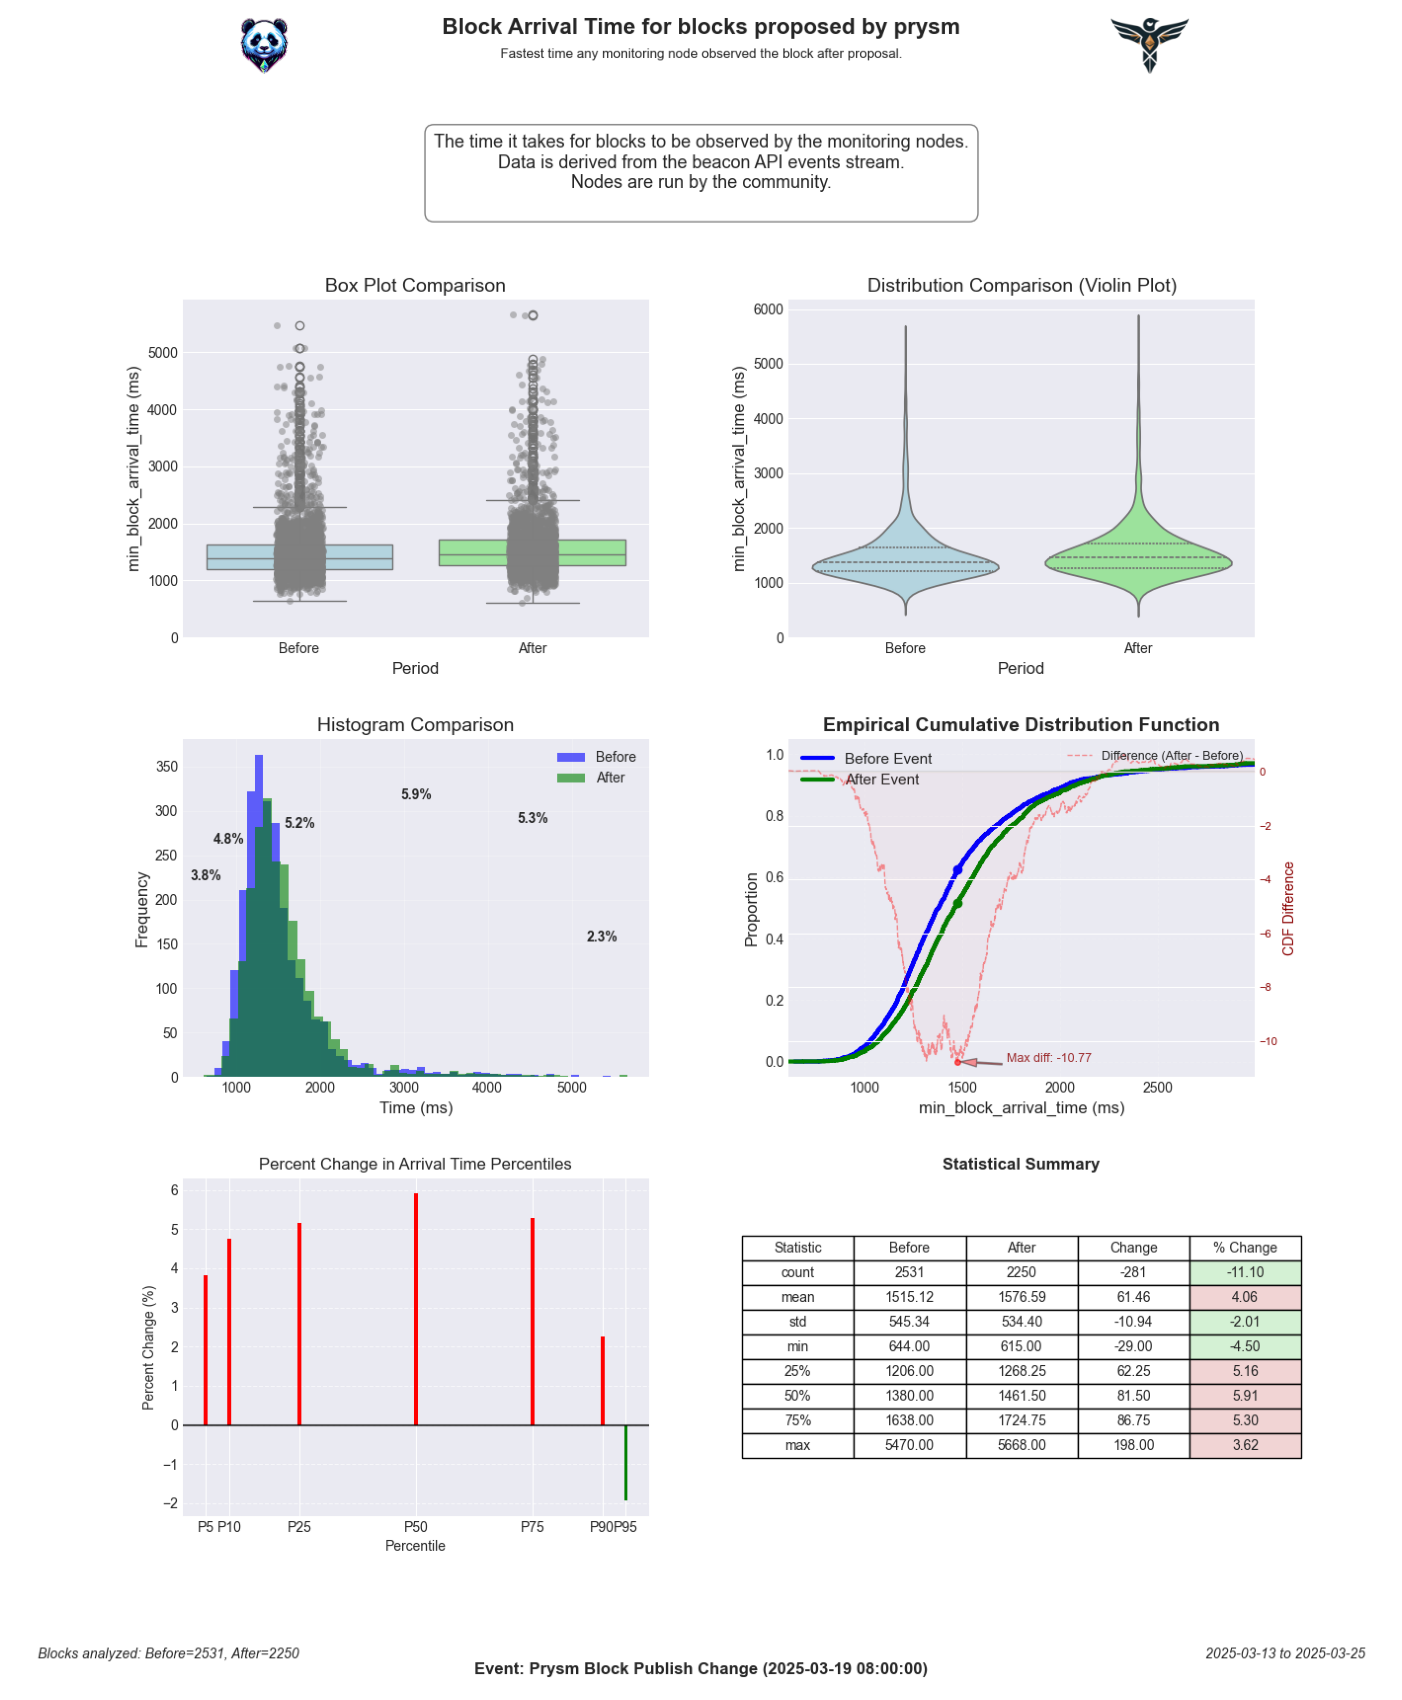

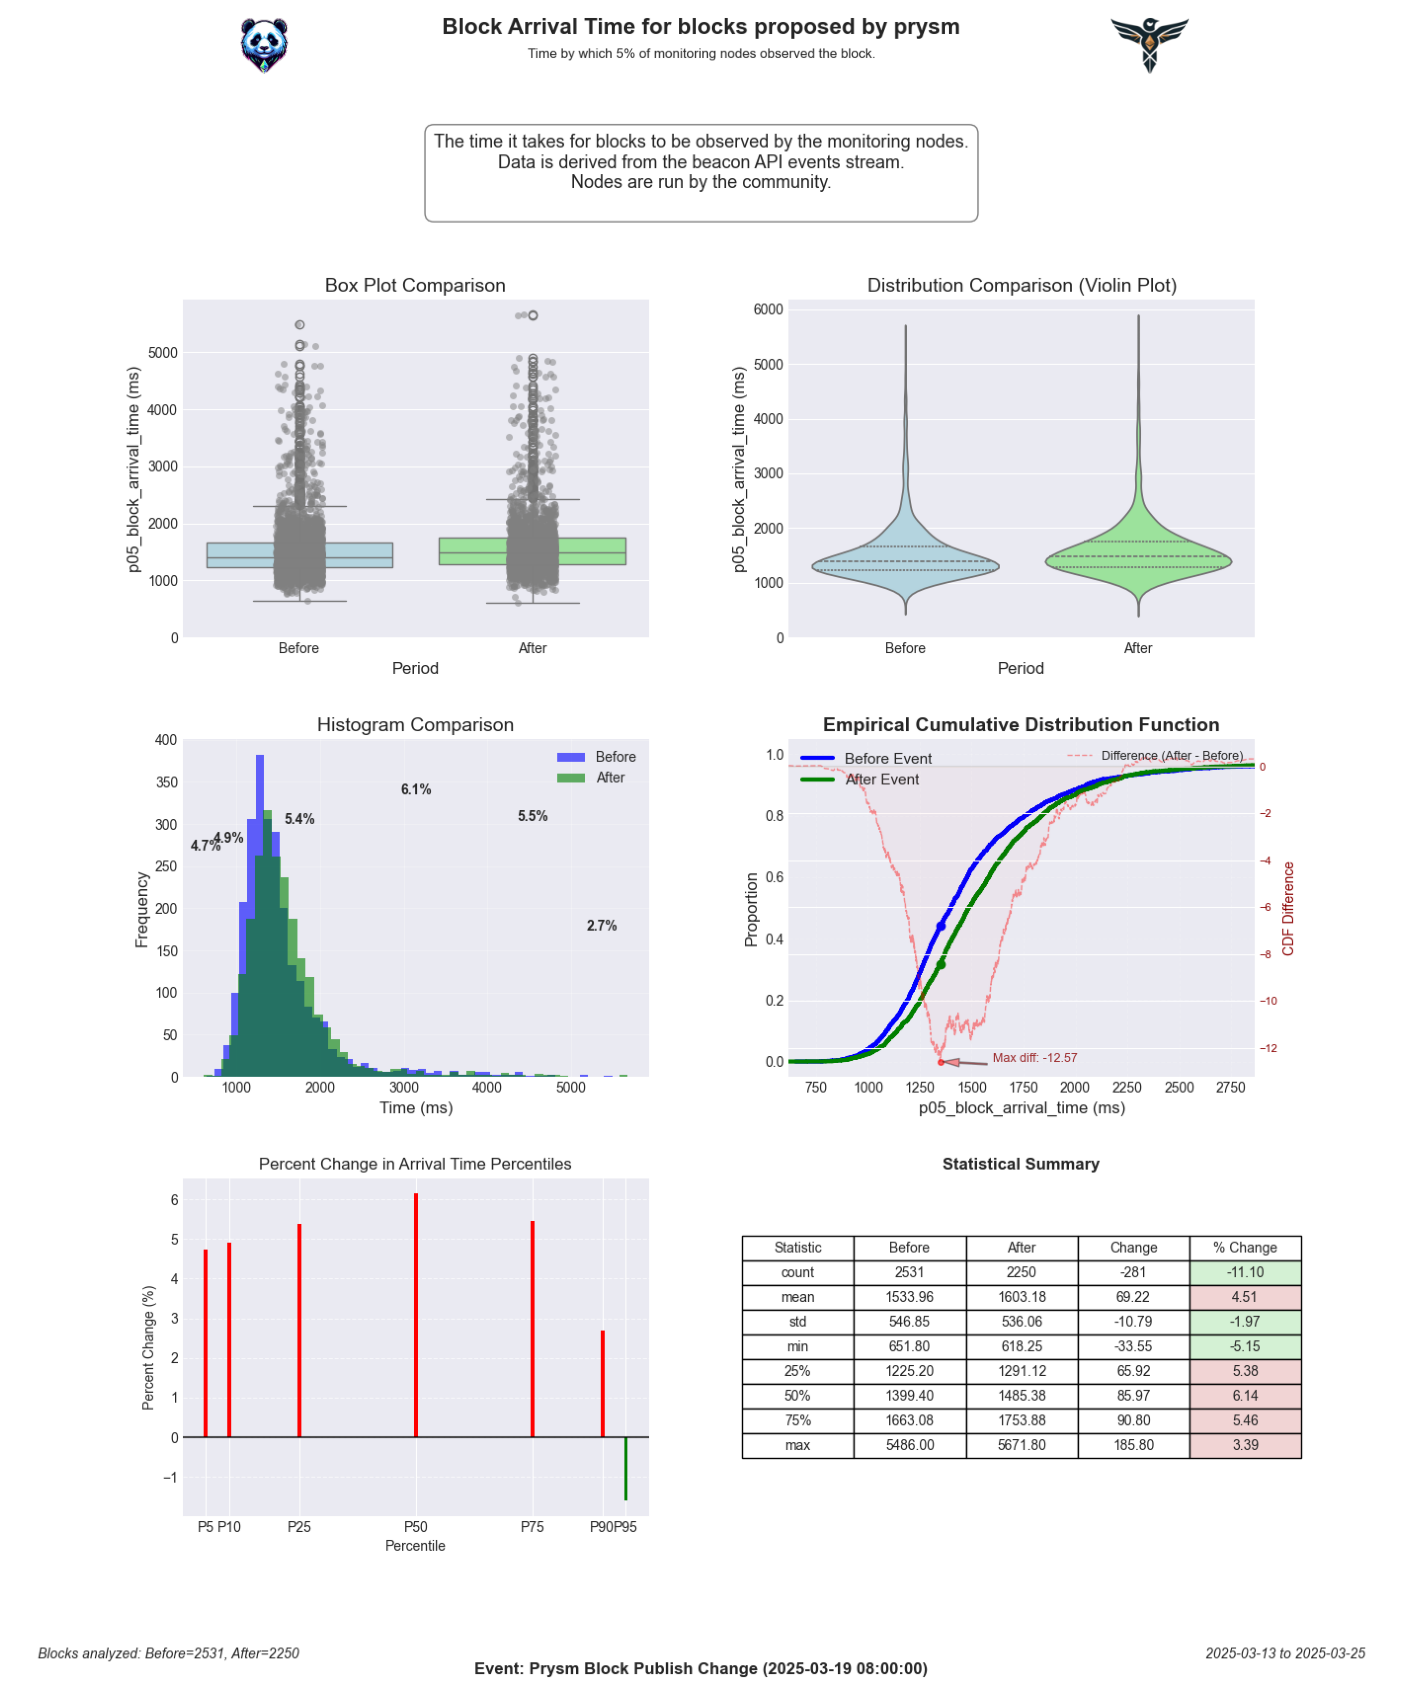

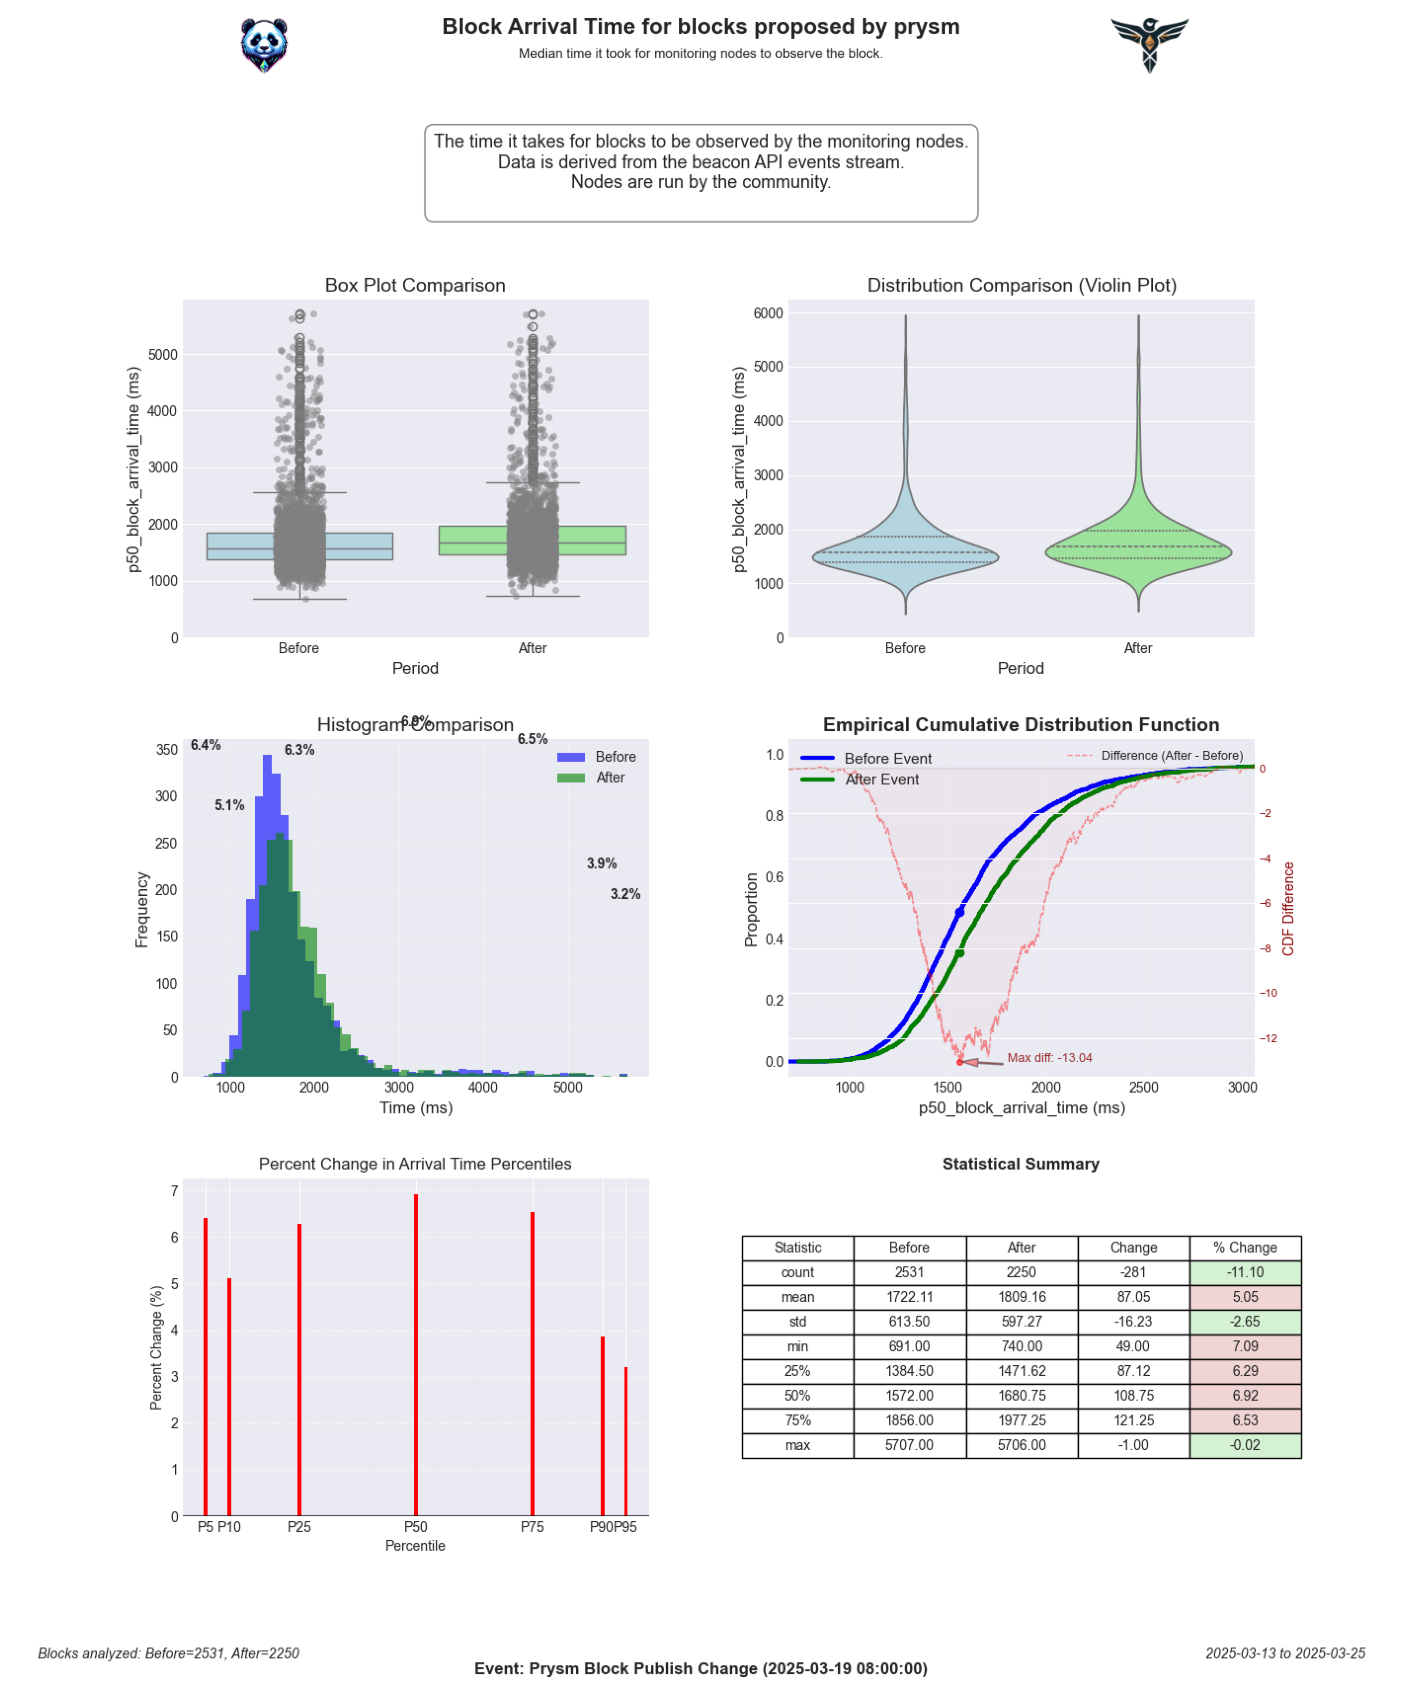

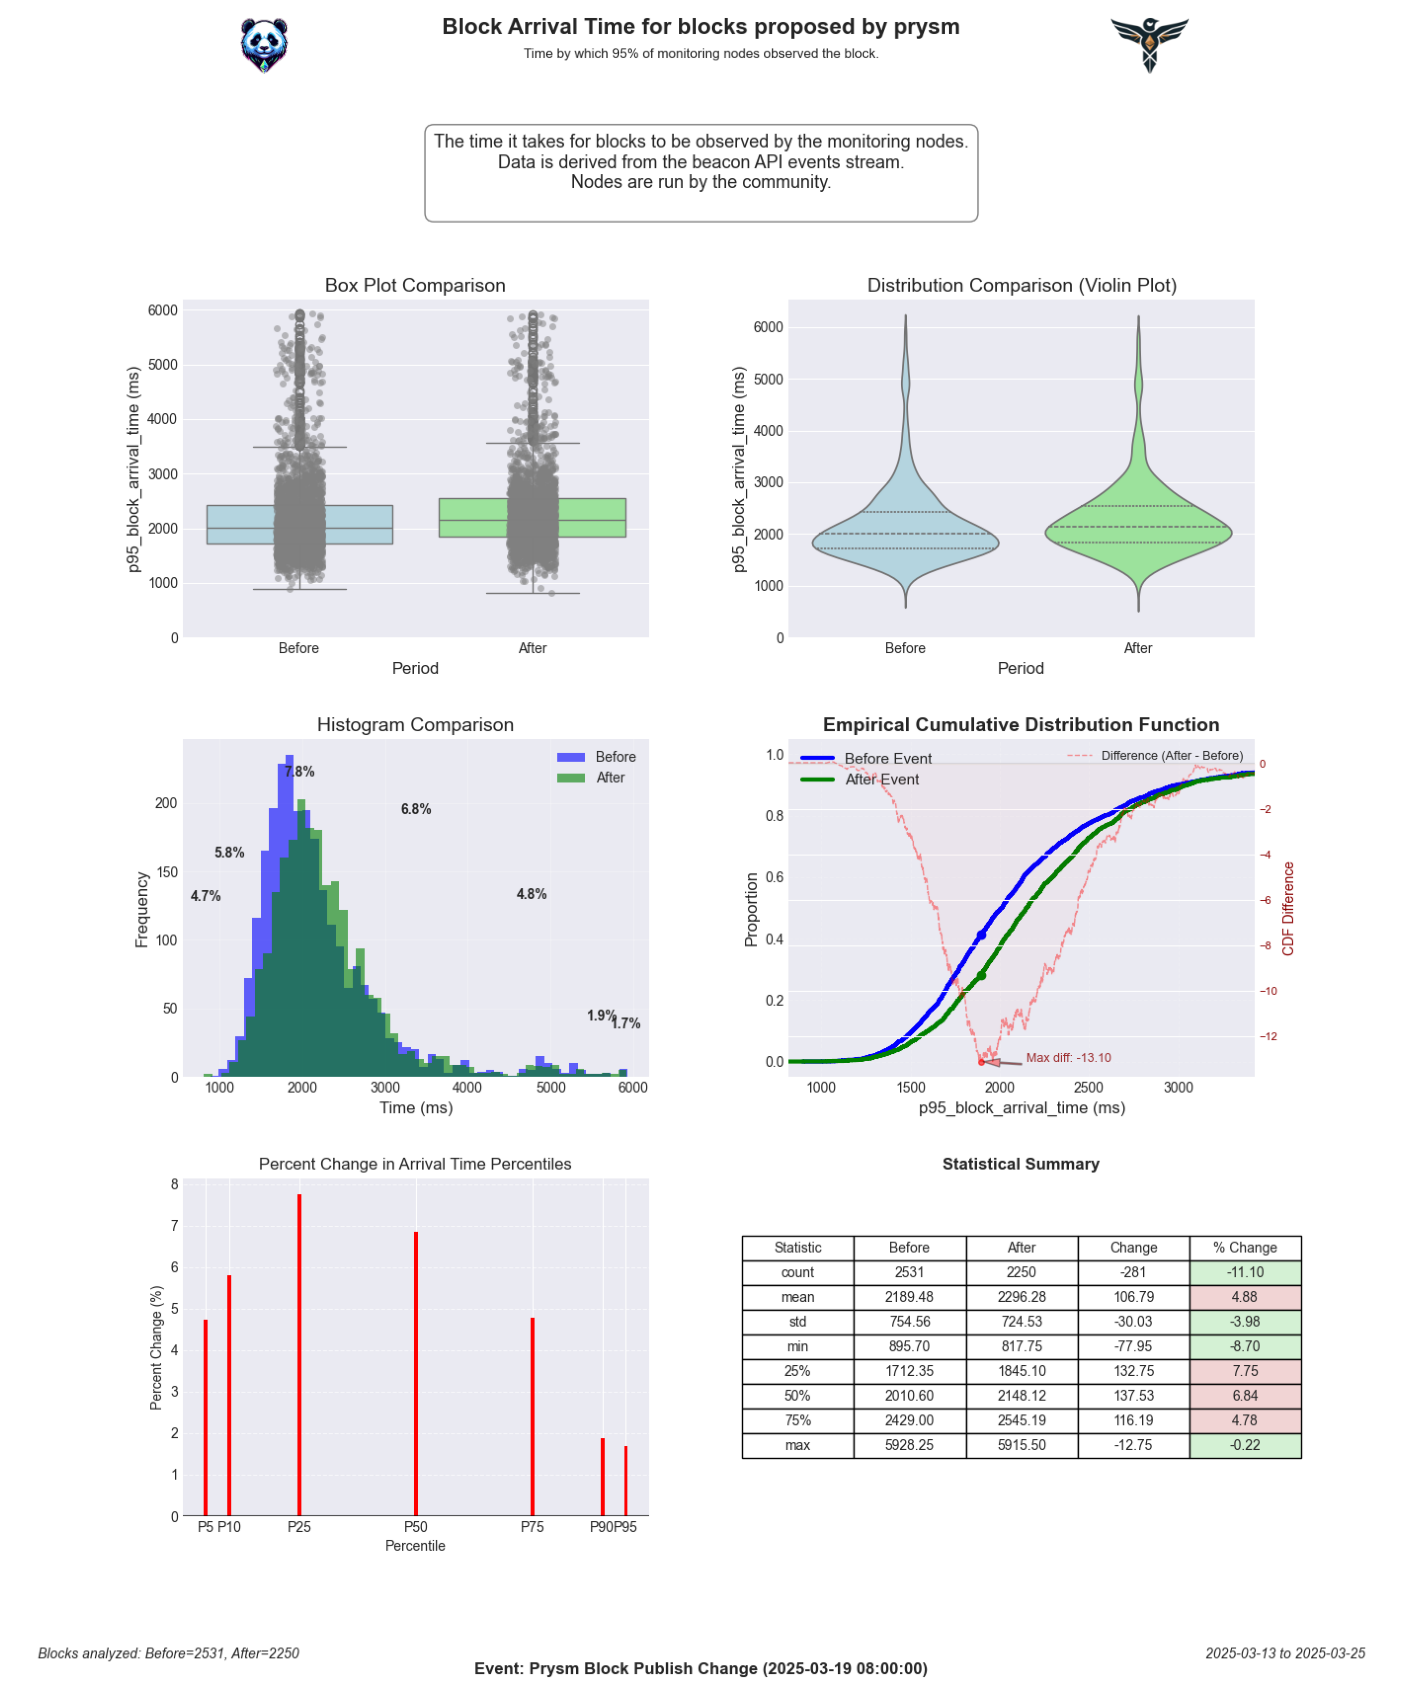

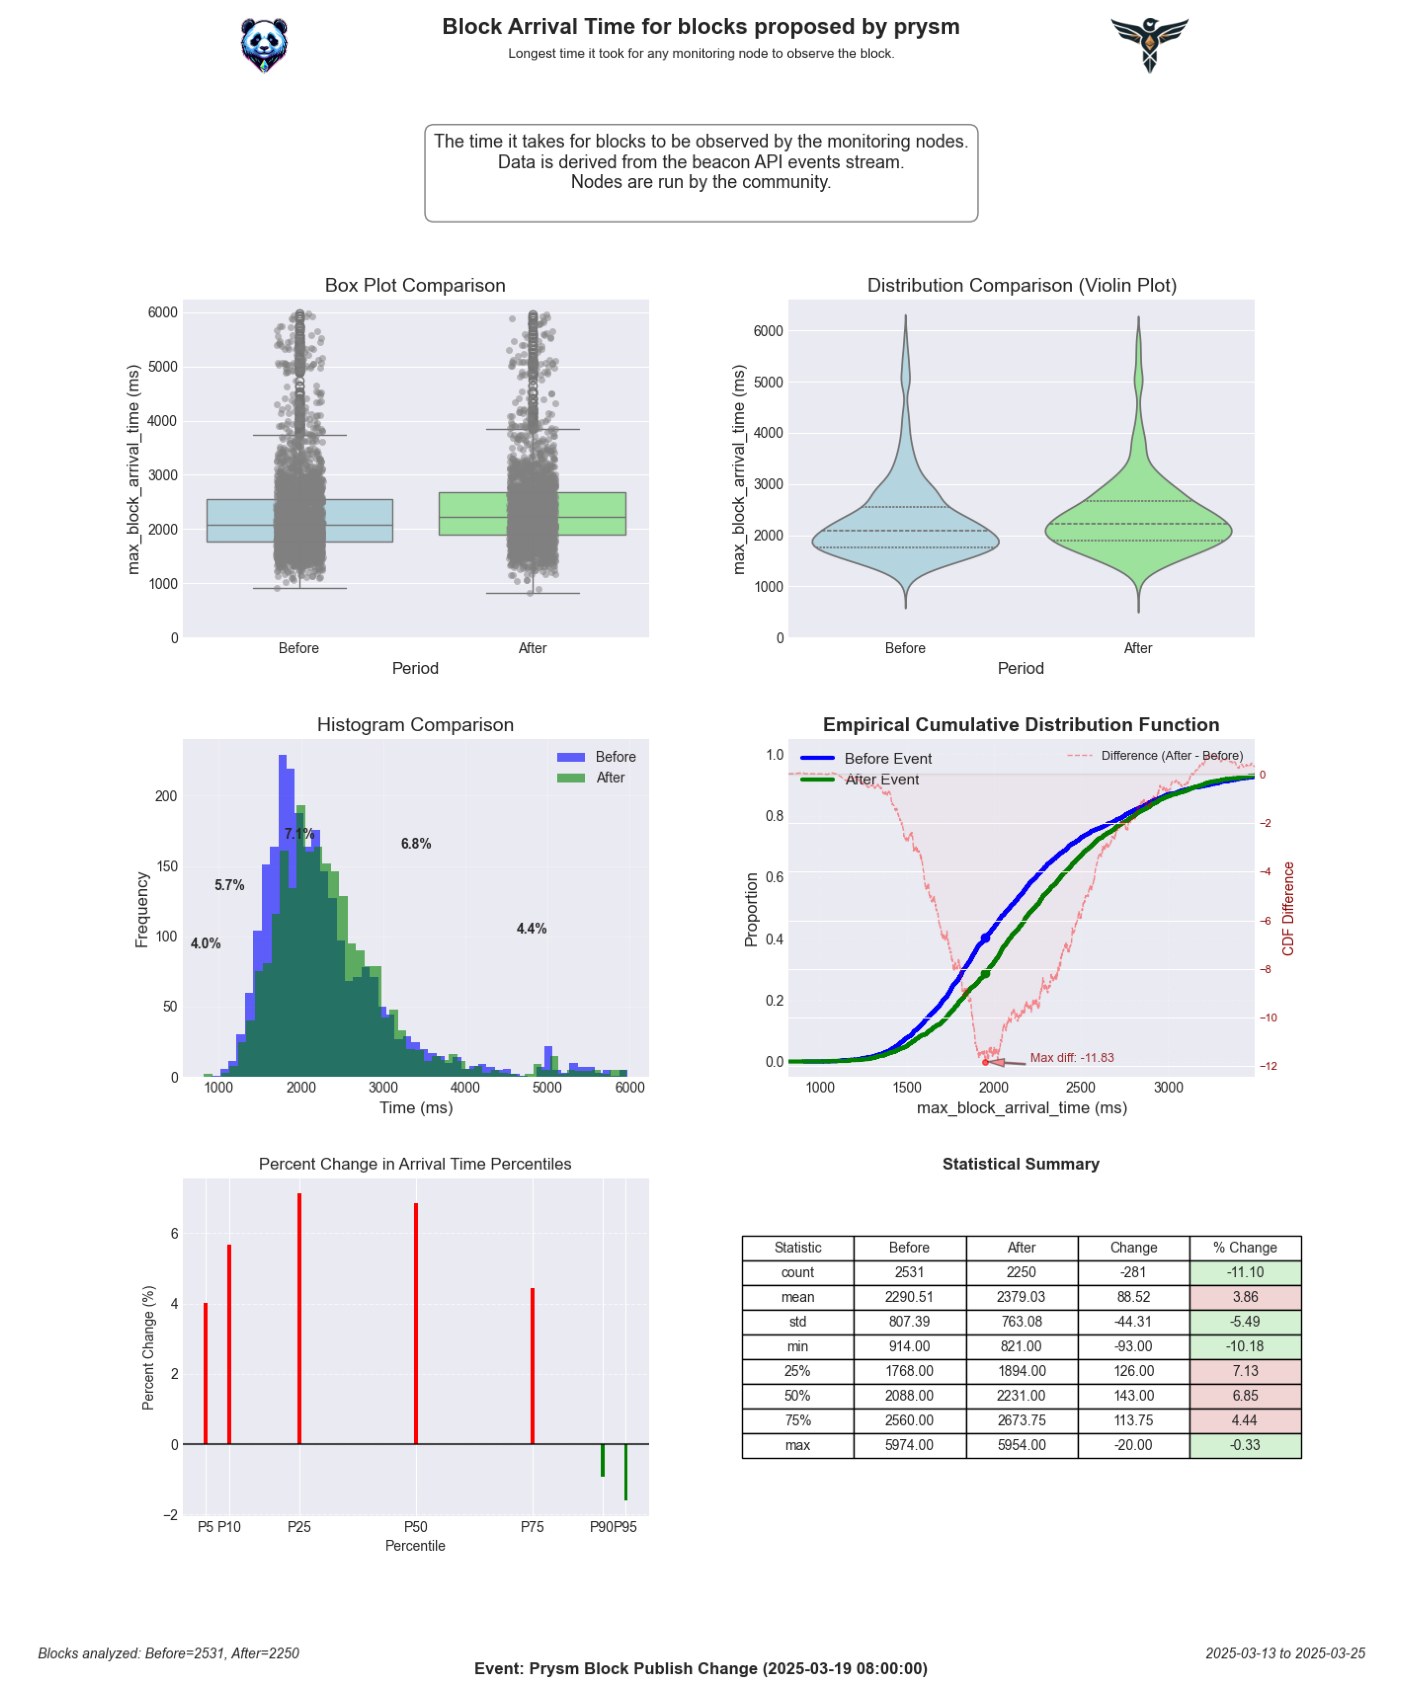

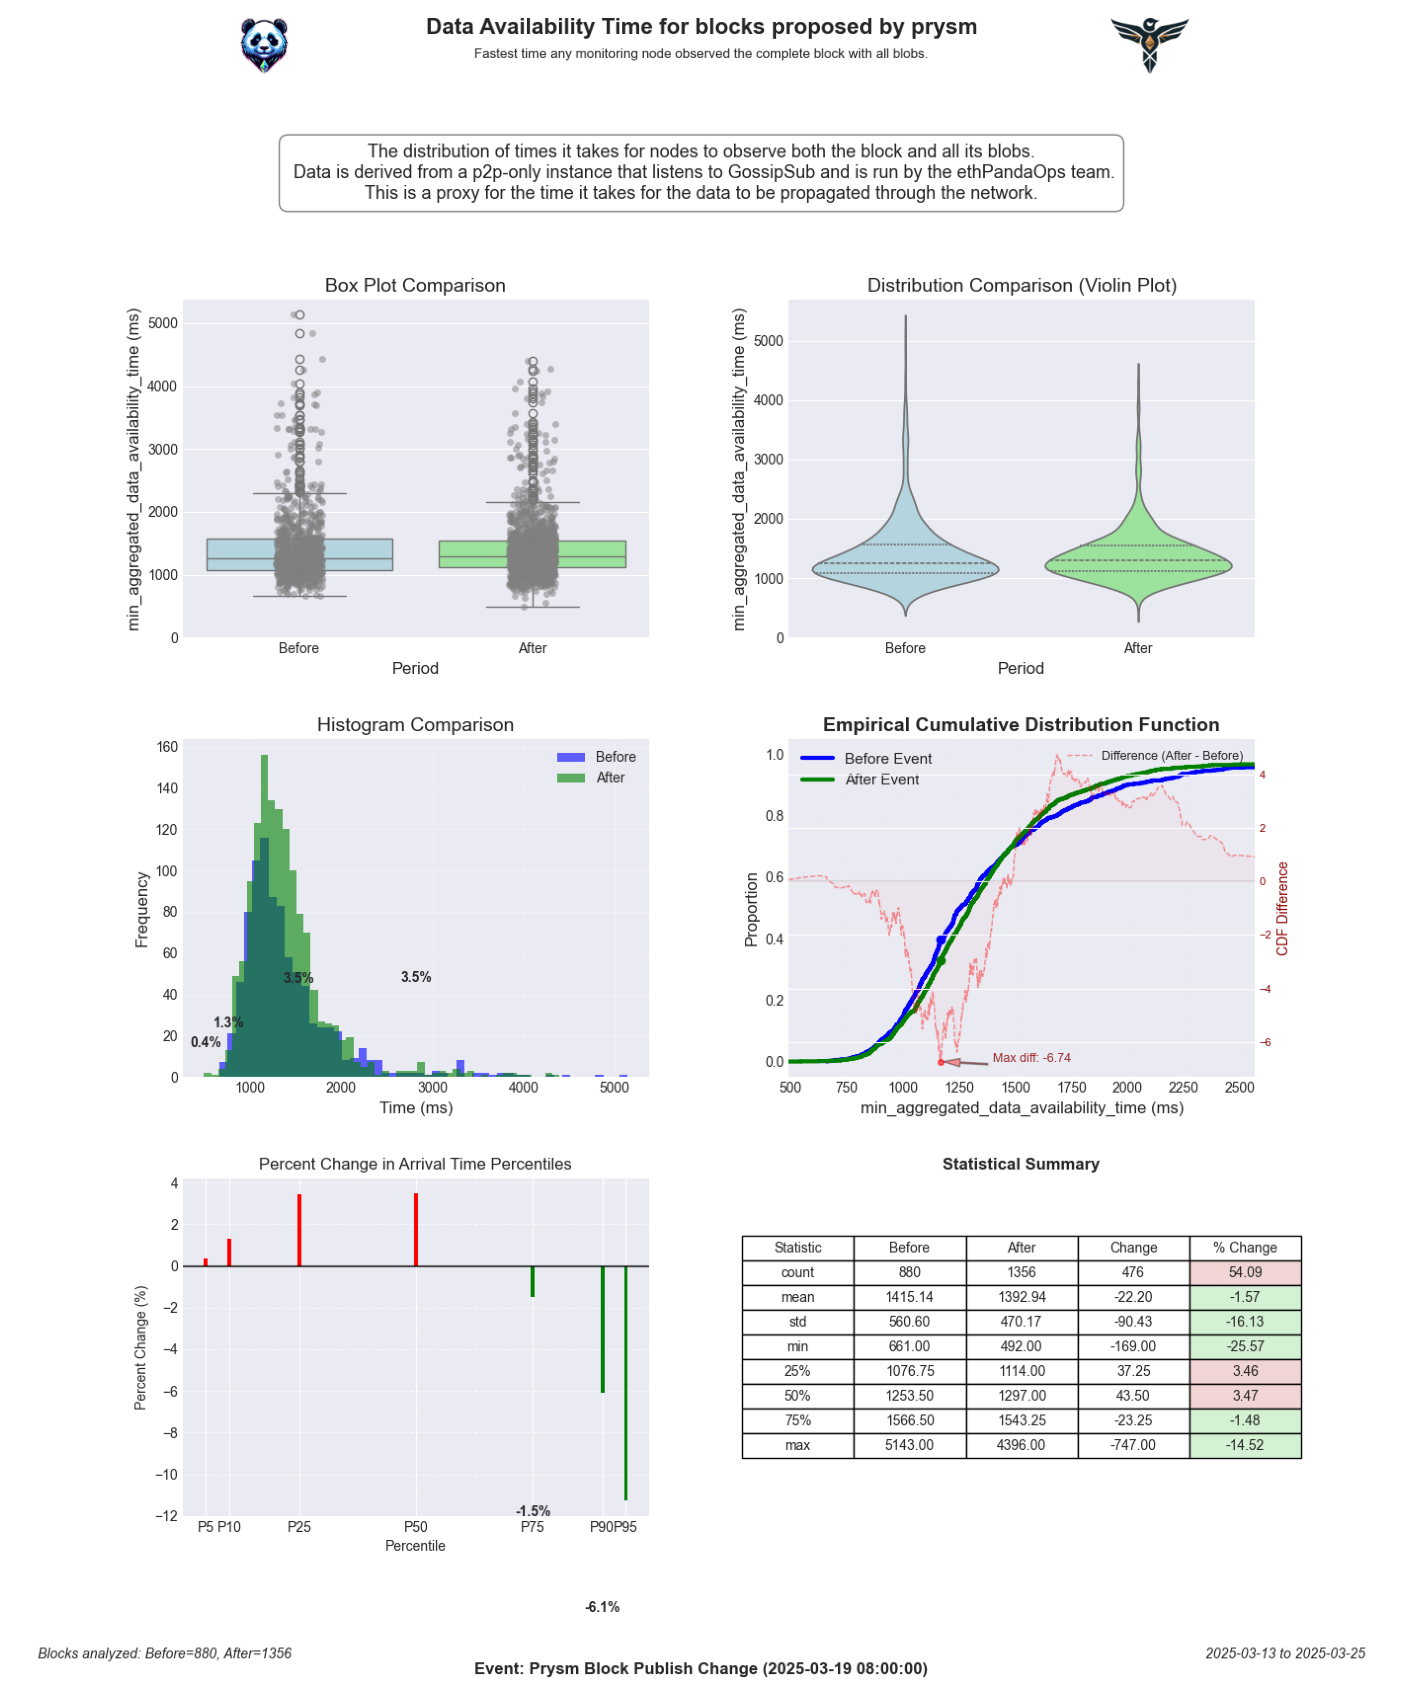

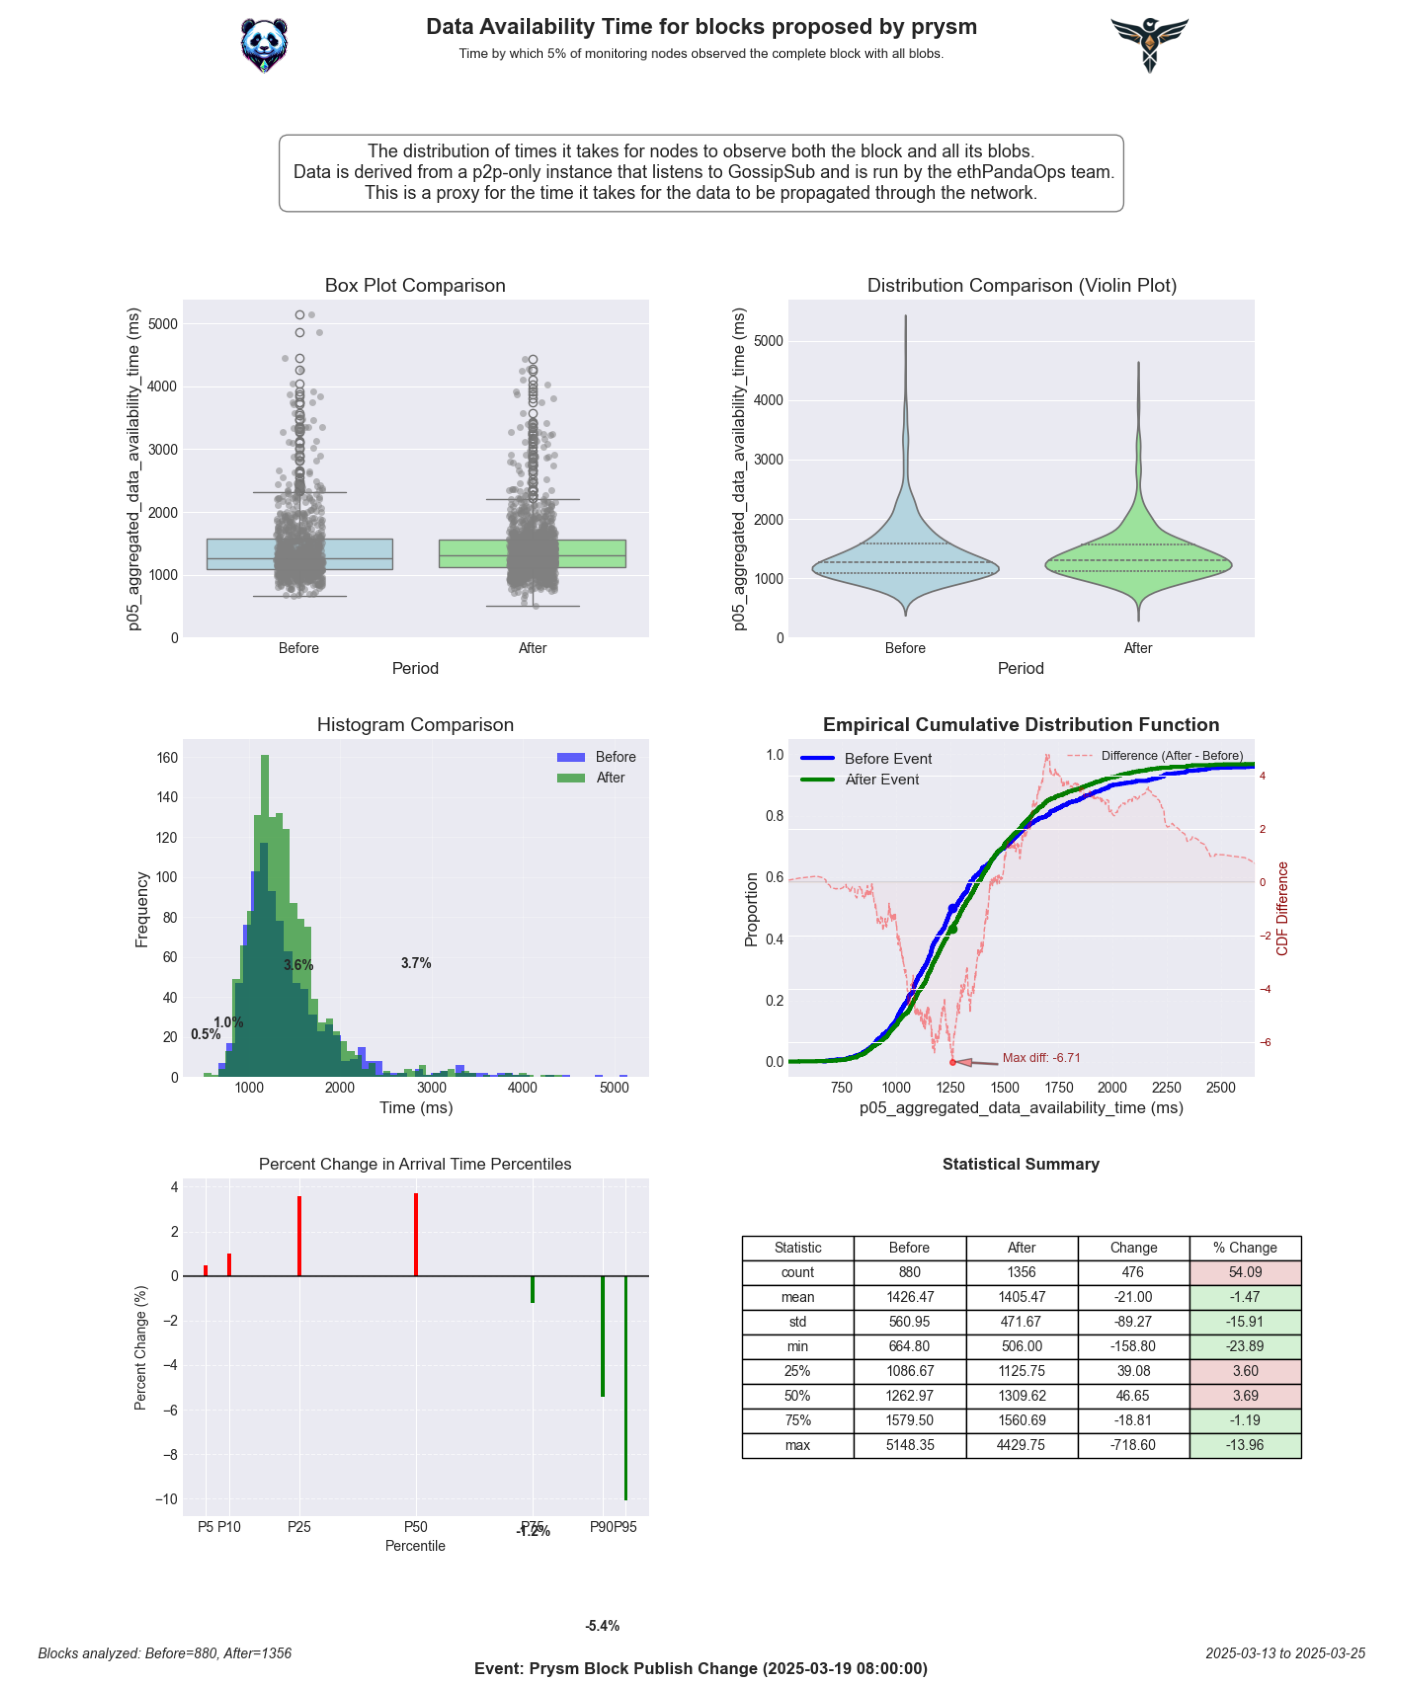

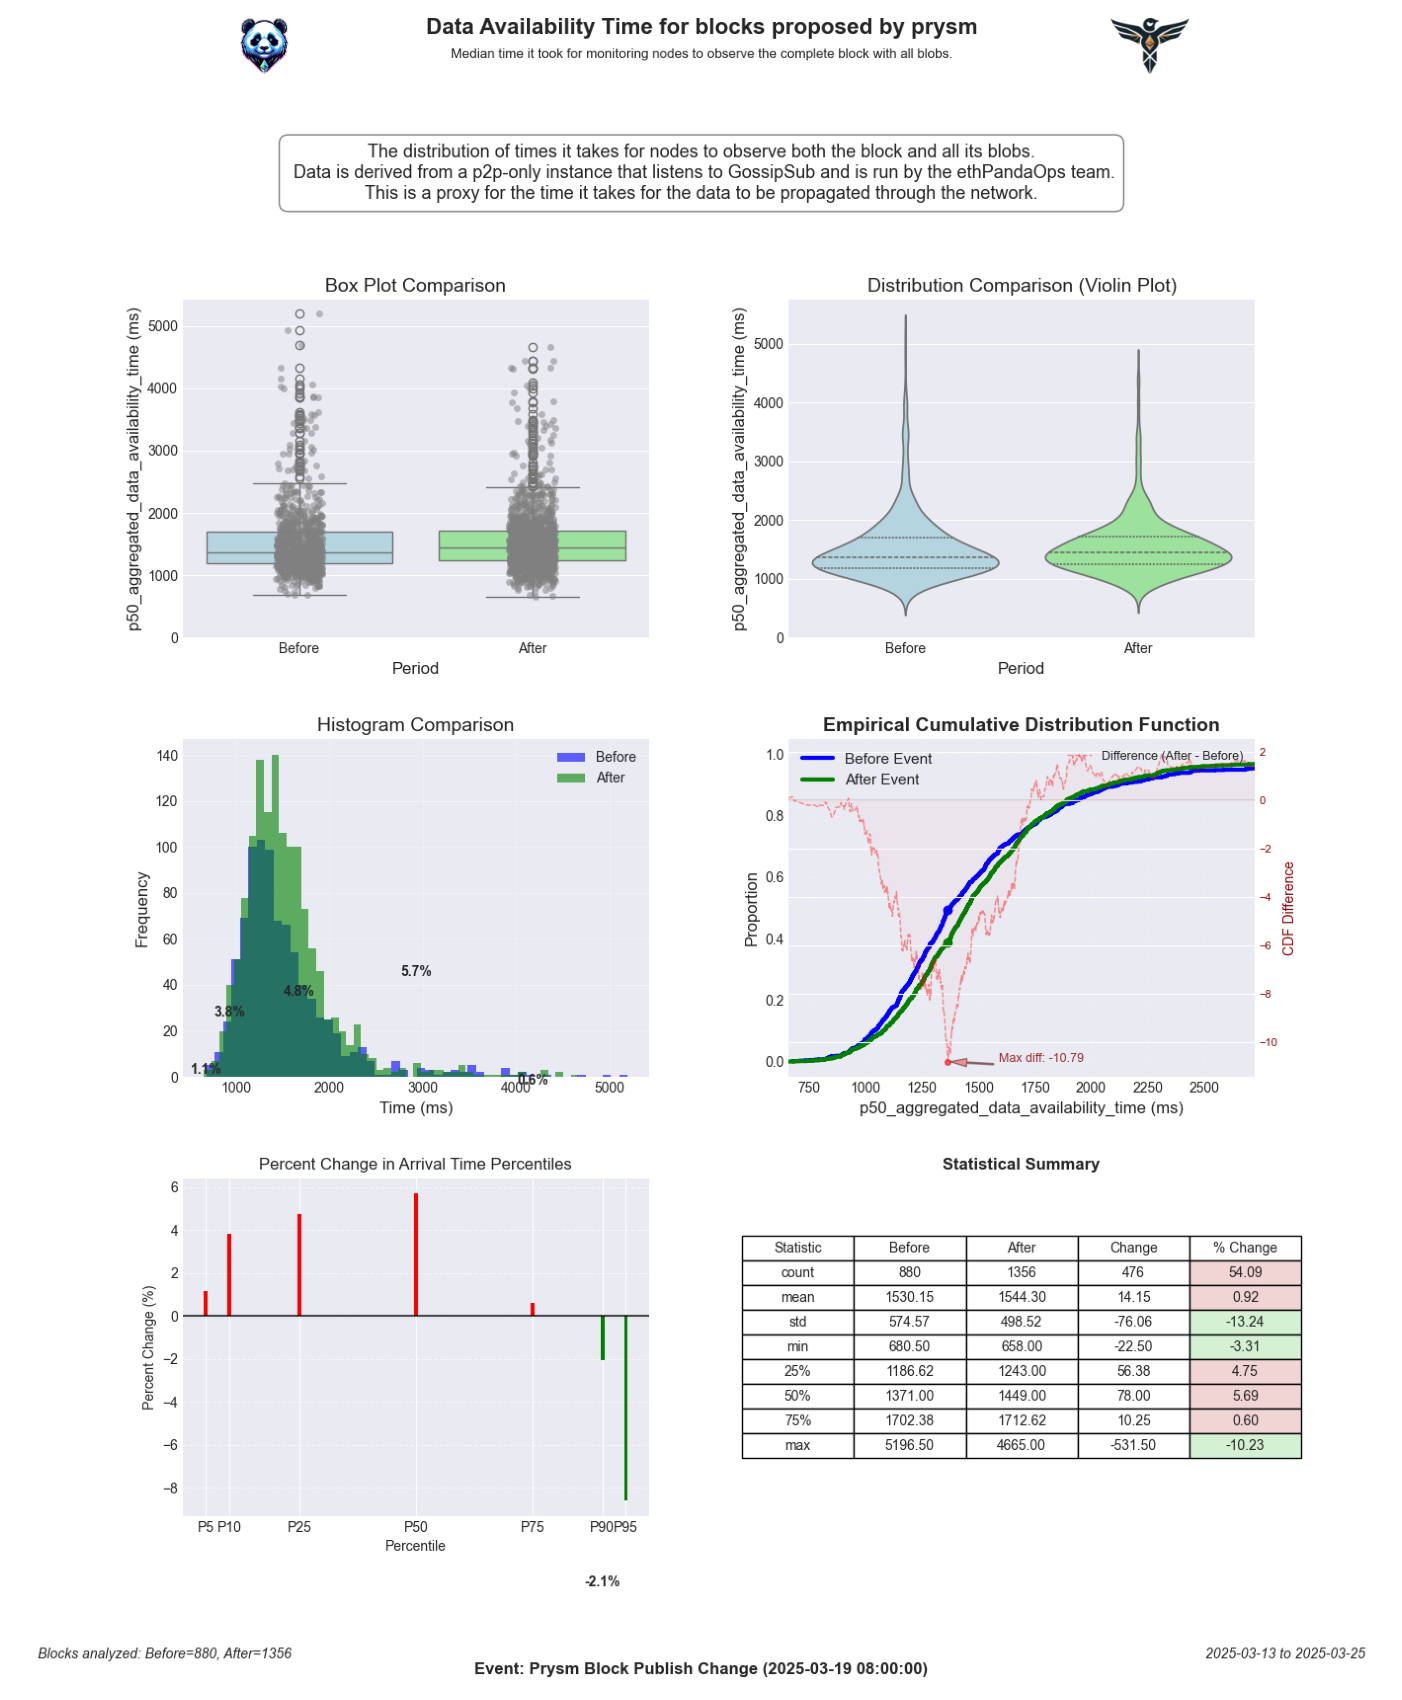

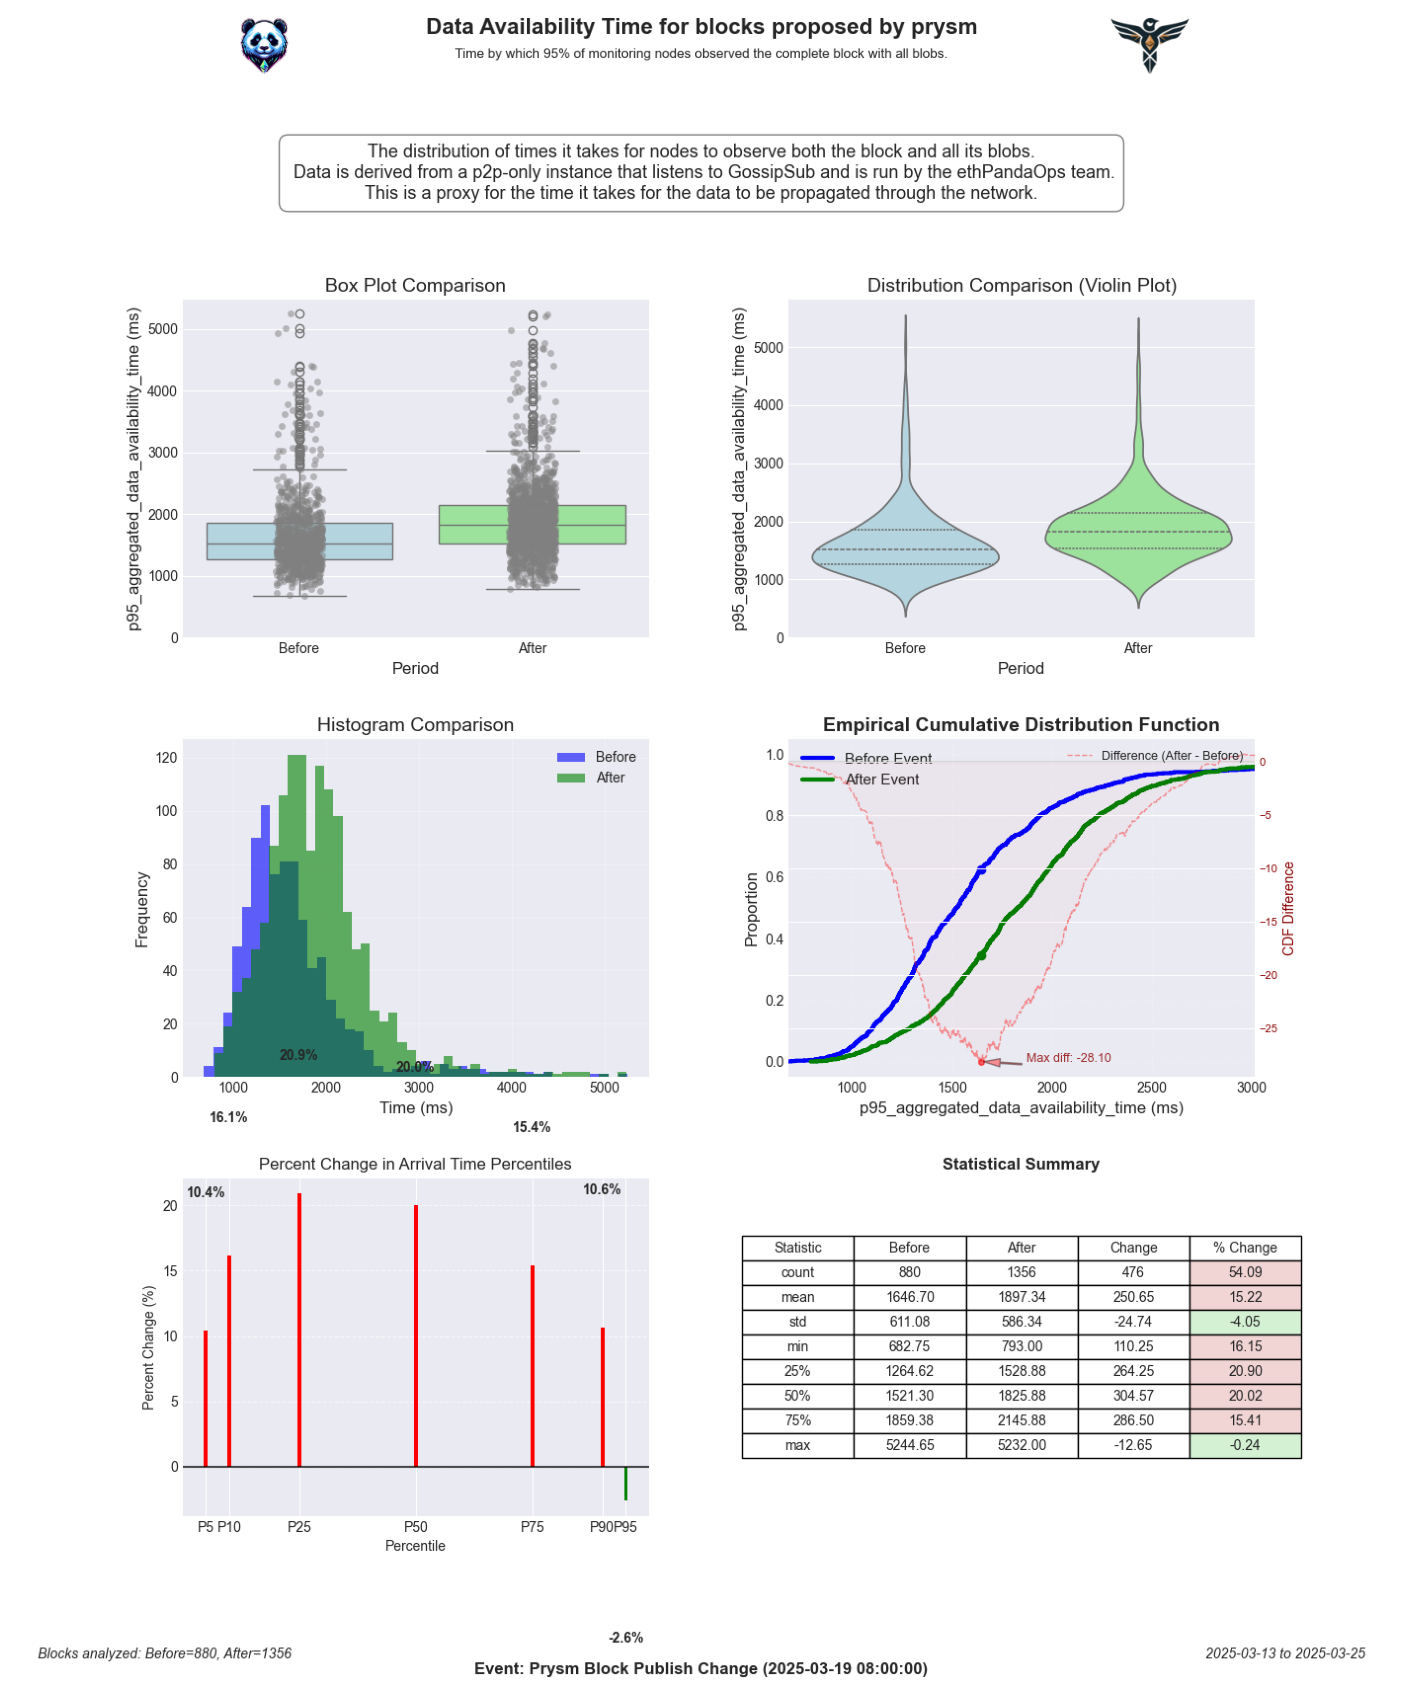

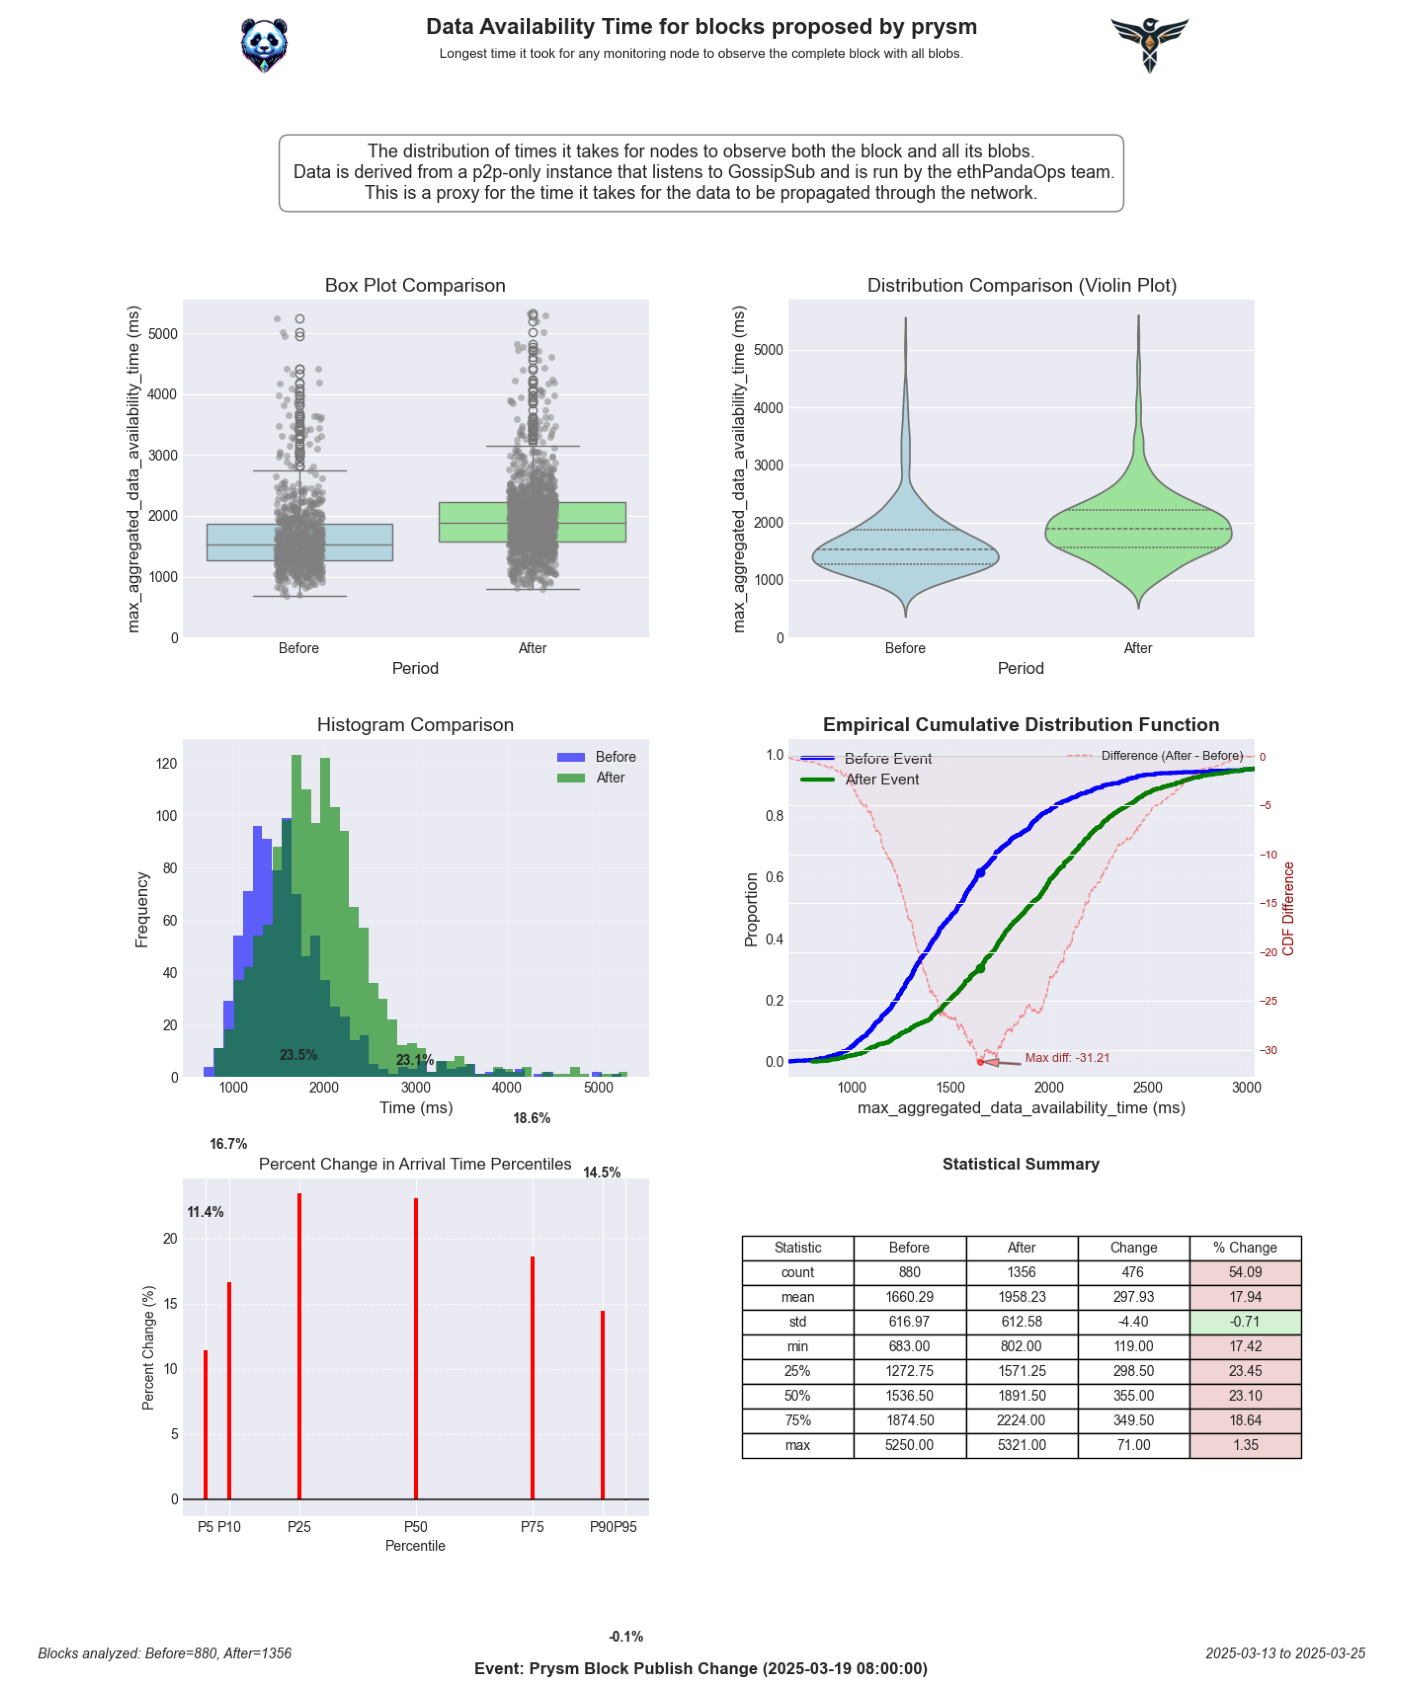

In [42]:
def plot_performance_before_after_by_entity(entity_name, metric='min_block_arrival_time', data=combined_data, validators_map=validators):
    """
    Creates a before/after comparison plot of block arrival times for a specific entity,
    using the specified metric for each block.
    
    Args:
        entity_name (str): The name of the entity to filter by
        metric (str): The metric to use for comparison (e.g., 'min_block_arrival_time', 'p05_block_arrival_time')
        data (DataFrame): The combined data containing arrival times
        validators_map (dict): Mapping of validator indices to entities
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.dates as mdates
    from matplotlib.ticker import FuncFormatter

    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Prepare data
    valid_data = prepare_entity_data(entity_name, metric, data, validators_map)
    if valid_data is None:
        return None
    
    # Create before/after groups
    valid_data['period'] = np.where(valid_data['timestamp'] < event_date, 'Before', 'After')
    
    # Create a figure with multiple subplots - now with 6 visualizations
    fig = plt.figure(figsize=(14, 16))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # Original plots
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    
    # New plots
    ax5 = fig.add_subplot(gs[2, 0])
    ax6 = fig.add_subplot(gs[2, 1])
    
    # Create original plots
    create_boxplot(valid_data, metric, ax1)
    create_violinplot(valid_data, metric, ax2)
    create_histogram(valid_data, ax3)
    create_ecdf_plot(valid_data, metric, ax4)
    
    # Create new visualizations
    create_percentile_comparison_plot(valid_data, ax5)
    
    # Create stats summary table
    before_stats = valid_data[valid_data['period'] == 'Before']['min_time'].describe()
    after_stats = valid_data[valid_data['period'] == 'After']['min_time'].describe()
    
    # Create a table for the stats
    stats_data = pd.DataFrame({
        'Statistic': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'],
        'Before': before_stats.values,
        'After': after_stats.values,
        'Change': after_stats.values - before_stats.values,
        '% Change': (after_stats.values - before_stats.values) / before_stats.values * 100
    })
    
    # Convert values to strings with formatting to avoid the rounding error
    formatted_data = []
    for i, row in stats_data.iterrows():
        if i == 0:  # For count, use integer format
            formatted_row = [row['Statistic'], 
                            f"{row['Before']:.0f}", 
                            f"{row['After']:.0f}", 
                            f"{row['Change']:.0f}", 
                            f"{row['% Change']:.2f}"]
        else:  # For other stats, use float format
            formatted_row = [row['Statistic'], 
                            f"{row['Before']:.2f}", 
                            f"{row['After']:.2f}", 
                            f"{row['Change']:.2f}", 
                            f"{row['% Change']:.2f}"]
        formatted_data.append(formatted_row)
    
    # Hide axes
    ax6.axis('off')
    
    # Create table with pre-formatted text
    table = ax6.table(
        cellText=formatted_data,
        colLabels=stats_data.columns,
        loc='center',
        cellLoc='center'
    )
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    # Color code the % change column
    for i in range(1, len(stats_data) + 1):
        cell = table[(i, 4)]  # % Change column
        if i > 0:  # Skip header
            value = stats_data['% Change'].values[i-1]
            if not np.isnan(value):
                if value < 0:
                    cell.set_facecolor('#d4f1d4')  # light green
                elif value > 0:
                    cell.set_facecolor('#f1d4d4')  # light red
    
    ax6.set_title('Statistical Summary', fontsize=12, fontweight='bold')
    
    # Add statistics and annotations
    add_statistics_and_annotations(fig, valid_data, event_date)

    # Find the metric category and description
    metric_category = None
    metric_description = None
    category_description = None
    
    for category, data in metrics.items():
        if metric in data["metrics"]:
            metric_category = category
            category_description = data['description']
            metric_description = data['metrics'][metric]
            break
    
    # Add branding
    title = f"{metric_category} for blocks proposed by {entity_name}"
    subtitle = f"{metric_description}"
    
    # Add description as plain text in a box
    if category_description:
        # Create a box with description text
        box_props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5)
        fig.text(0.5, 0.96, category_description, 
                ha='center', va='center', 
                fontsize=13, 
                wrap=True,
                bbox=box_props)
        
    add_branding(fig, title=title, subtitle=subtitle)
    plt.tight_layout()
    # Adjust margins to accommodate the description
    plt.subplots_adjust(top=0.9, bottom=0.1)
    return plt

# Loop through all metrics defined in the metrics dictionary
for category, category_data in metrics.items():
    if isinstance(category_data, dict) and "metrics" in category_data:
        for metric in category_data["metrics"]:
            plot_performance_before_after_by_entity("prysm", metric=metric)
        

<module 'matplotlib.pyplot' from '/Users/samcm/.asdf/installs/python/3.11.4/lib/python3.11/site-packages/matplotlib/pyplot.py'>

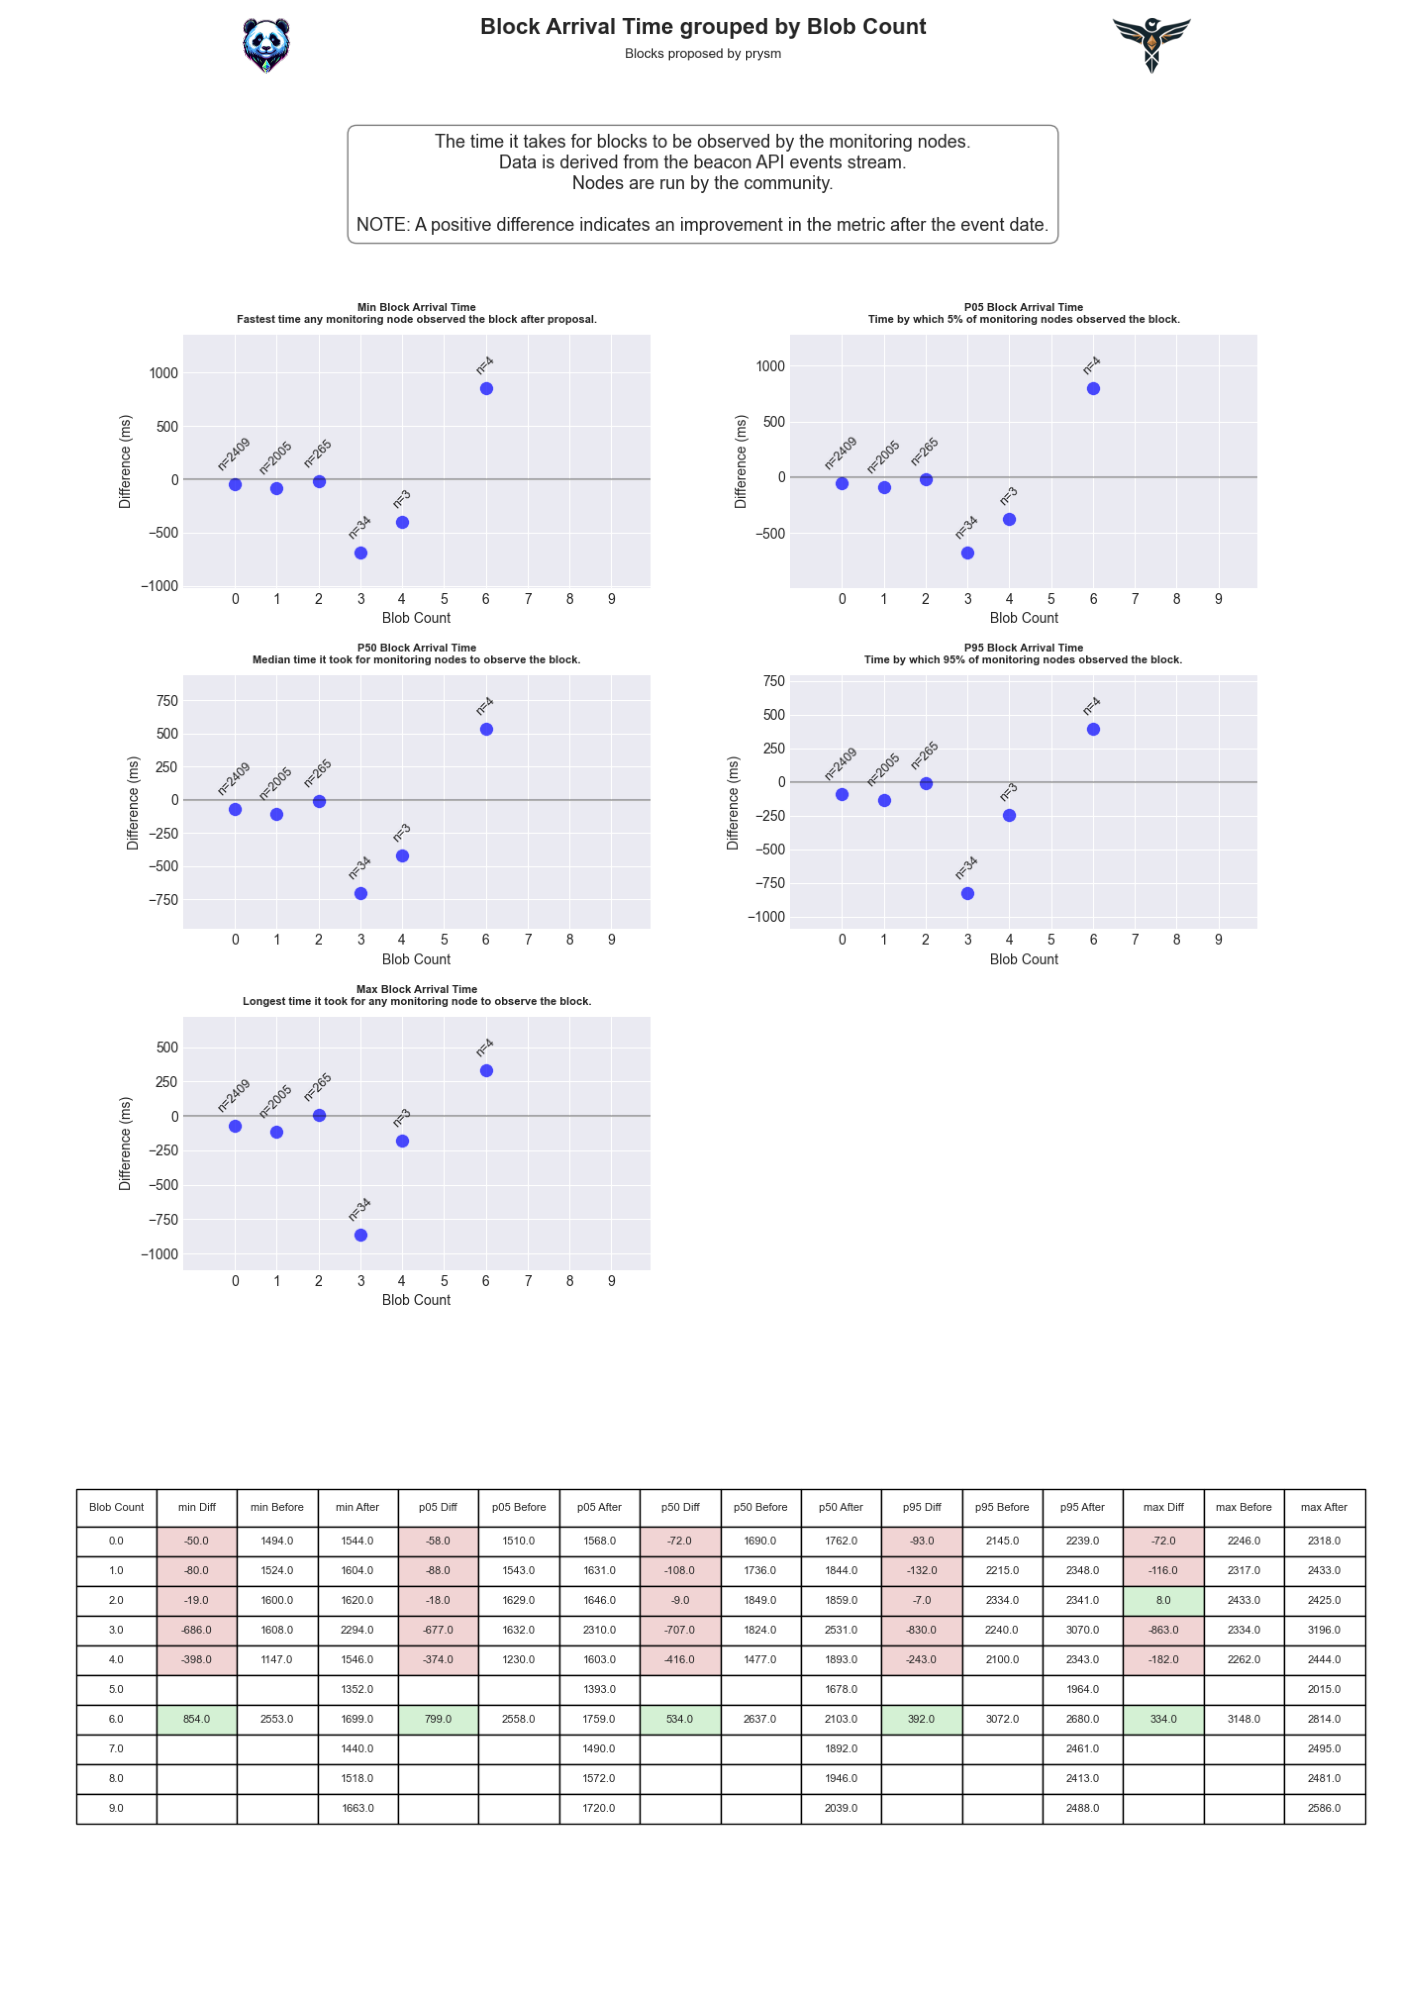

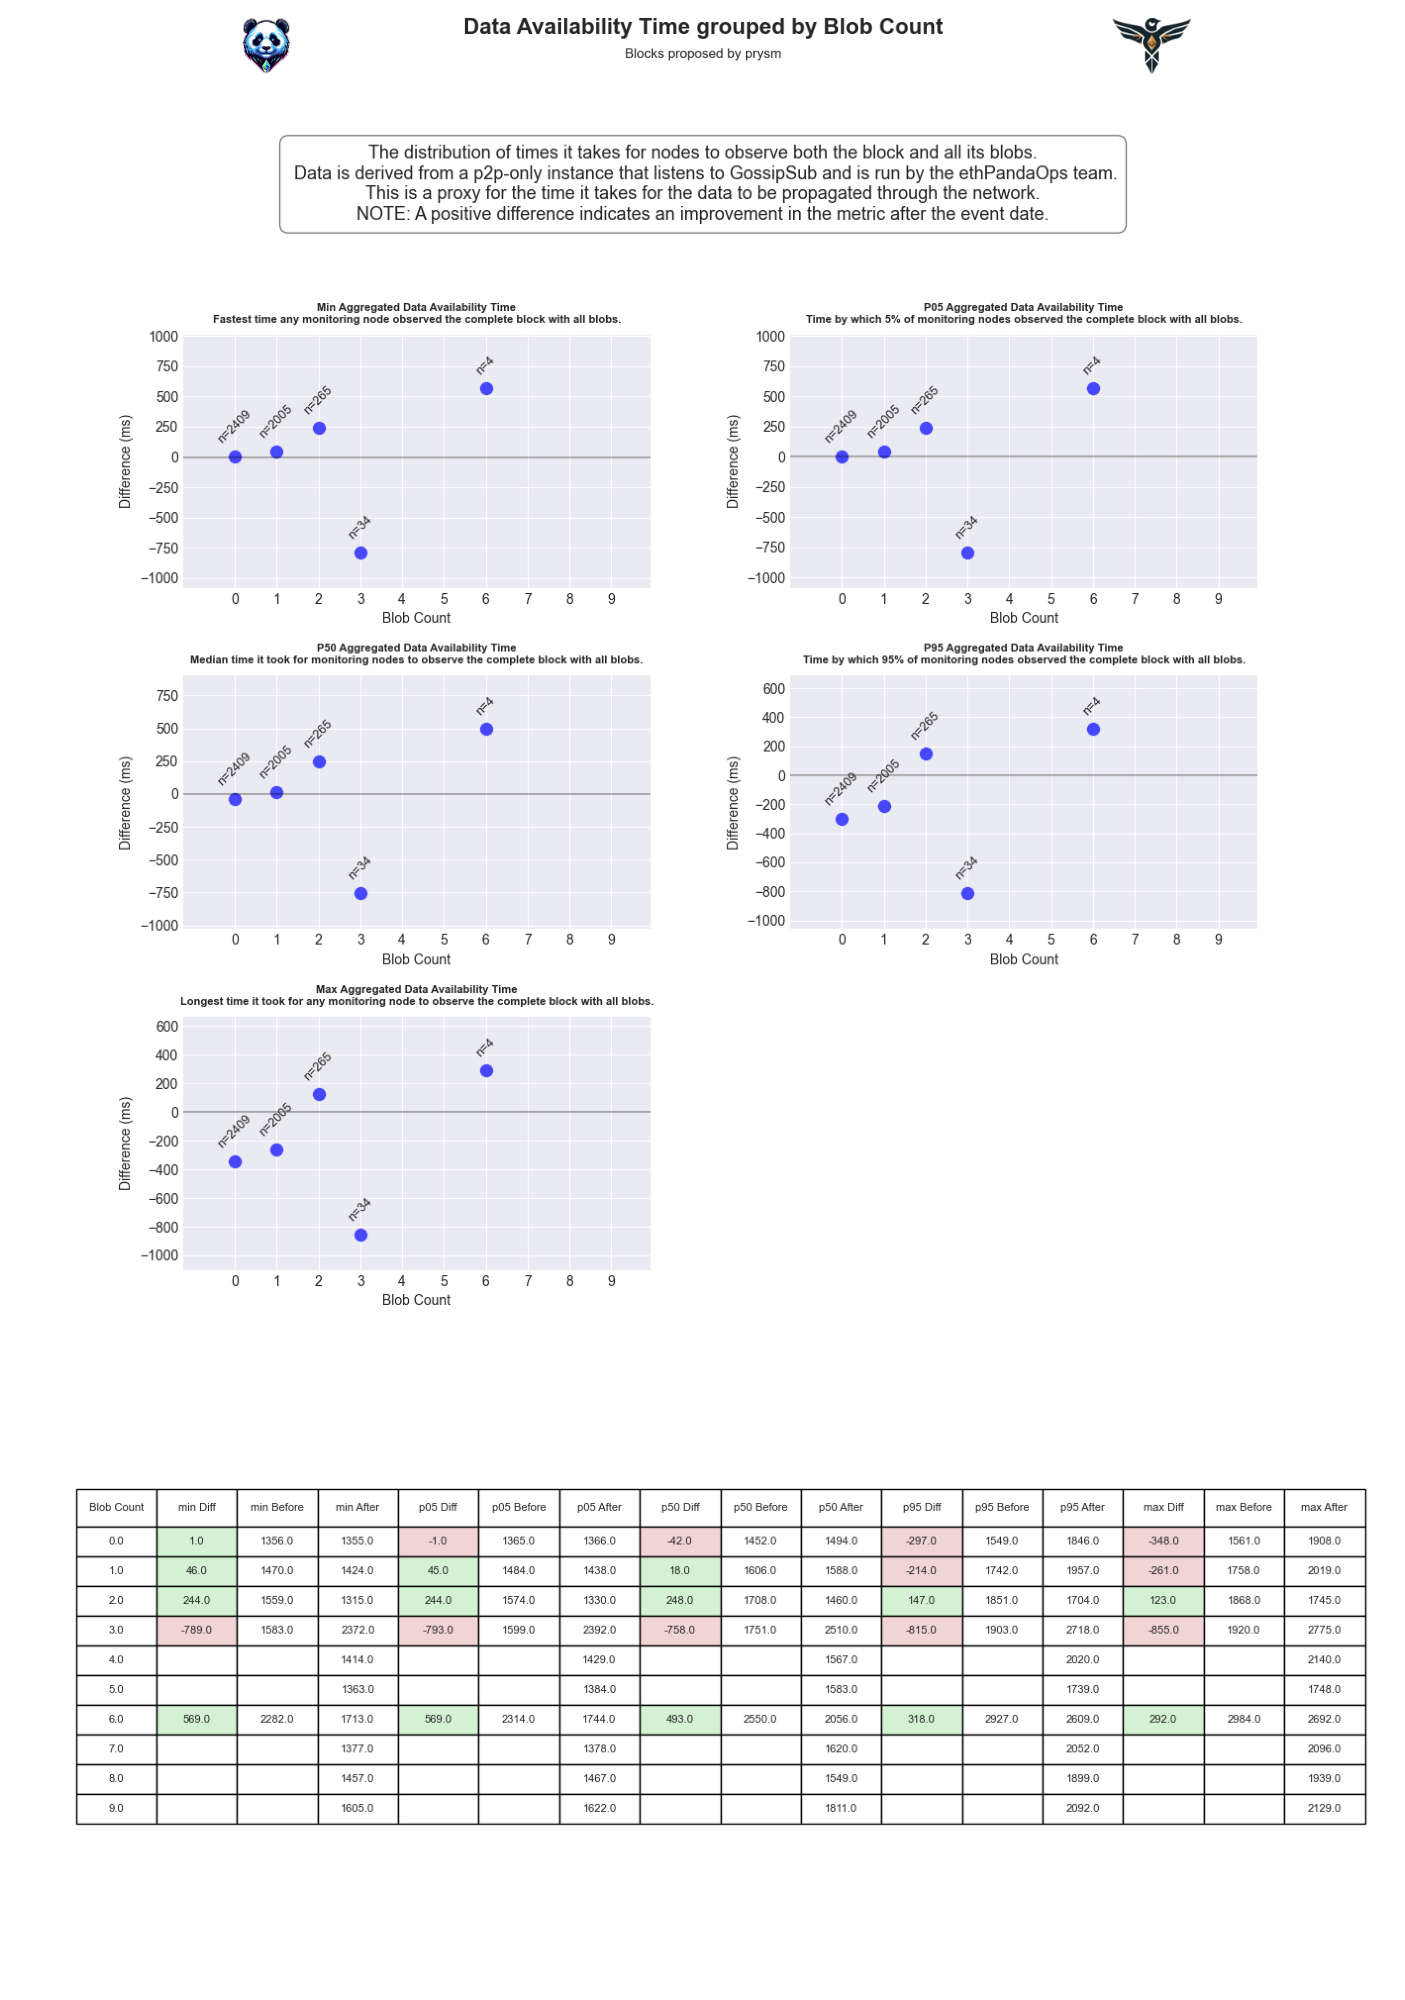

In [59]:
def plot_metrics_by_blob_count(entity_name, metric_group, title=""):
    """
    Creates a comprehensive visualization showing all metrics before and after 
    the event date, with points color-coded by blob count.
    
    Args:
        entity_name (str): The name of the entity to analyze
        metric_group (str): The metric group to plot (key from metrics dictionary)
        title (str): Title for the plot
    
    Returns:
        matplotlib.pyplot: The plot object
    """
    # Get metrics and description from the metric group
    if metric_group not in metrics:
        return None
    
    metrics_to_plot = list(metrics[metric_group]["metrics"].keys())
    description = metrics[metric_group]["description"]
    
    # Prepare data for the entity
    entity_data = prepare_entity_data(entity_name)
    if entity_data is None:
        return None
    
    # Convert the time column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(entity_data['time']):
        entity_data['time'] = pd.to_datetime(entity_data['time'])
    
    # Convert event_date to timestamp for comparison
    event_timestamp = pd.Timestamp(event_date).timestamp()
    
    # Add timestamp column for easier comparison
    entity_data['timestamp'] = entity_data['time'].astype(int) // 10**9
    
    # Create figure with subplots for each metric
    fig = plt.figure(figsize=(14, 19))  # Increased height to accommodate table lower down
    
    # Create a grid for the plots - 4 rows, 2 columns with more space at bottom for table
    gs = fig.add_gridspec(5, 2, height_ratios=[3, 3, 3, 1, 3], hspace=0.4, wspace=0.3)
    
    # Create axes for each metric
    axes = []
    for i in range(len(metrics_to_plot)):
        row = i // 2
        col = i % 2
        ax = fig.add_subplot(gs[row, col])
        axes.append(ax)
    
    # Add a table at the bottom spanning both columns (now in the last row)
    table_ax = fig.add_subplot(gs[4, :])
    
    # Get unique blob counts
    blob_counts = sorted(entity_data['blob_count'].unique())
    
    # Store summary data for all metrics
    all_summary_data = []
    
    # Process each metric
    for idx, metric in enumerate(metrics_to_plot):
        # Create before and after datasets
        before_data = entity_data[entity_data['timestamp'] < event_timestamp]
        after_data = entity_data[entity_data['timestamp'] >= event_timestamp]
        
        # Skip if either dataset is empty
        if before_data.empty or after_data.empty:
            continue
        
        # Create a merged dataset with before and after metrics
        merged_data = []
        
        for blob_count in blob_counts:
            before_subset = before_data[before_data['blob_count'] == blob_count]
            after_subset = after_data[after_data['blob_count'] == blob_count]
            
            # Skip if both subsets are empty
            if before_subset.empty and after_subset.empty:
                continue
                
            # Calculate average metrics for each blob count
            before_value = before_subset[metric].mean() if not before_subset.empty else None
            after_value = after_subset[metric].mean() if not after_subset.empty else None
            
            # Only calculate difference if both values exist
            if before_value is not None and after_value is not None:
                difference = before_value - after_value
            else:
                difference = None
                
            # Only add to merged data if we have at least one value
            if before_value is not None or after_value is not None:
                merged_data.append({
                    'blob_count': blob_count,
                    'before_value': before_value if before_value is not None else float('nan'),
                    'after_value': after_value if after_value is not None else float('nan'),
                    'difference': difference if difference is not None else float('nan'),
                    'count': len(before_subset) + len(after_subset)
                })
        
        # Convert to DataFrame
        diff_df = pd.DataFrame(merged_data)
        
        # Skip if no data
        if diff_df.empty:
            continue
        
        # Create scatter plot for this metric
        ax = axes[idx]
        
        # Only plot points that have a valid difference
        valid_diff = diff_df.dropna(subset=['difference'])
        if not valid_diff.empty:
            # Use a consistent color for all points instead of a colormap
            ax.scatter(
                valid_diff['blob_count'],
                valid_diff['difference'],
                color='blue',
                alpha=0.7,
                s=100,  # Fixed size for all points
                edgecolors='w',
                linewidths=0.5
            )
        
        # Add a horizontal line at y=0
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        # Set labels and title for this chart
        ax.set_xlabel('Blob Count', fontsize=10)
        ax.set_ylabel('Difference (ms)', fontsize=10)
        
        # Get the metric description
        metric_description = metrics[metric_group]["metrics"][metric]
        
        # Create a combined title with metric name and description
        metric_name = metric.replace('_', ' ').title()
        title_text = metric_name
        
        if metric_description:
            title_text = f"{metric_name}\n{metric_description}"
            
        ax.set_title(title_text, fontsize=8, fontweight='bold', pad=10, wrap=True)
        
        # Add text labels for each point
        for i, row in diff_df.iterrows():
            if pd.notna(row['difference']):
                ax.annotate(
                    f"n={int(row['count'])}",
                    (row['blob_count'], row['difference']),
                    textcoords="offset points",
                    xytext=(0, 10),
                    ha='center',
                    rotation=45,
                    fontsize=9
                )
        # Set x-ticks to blob counts
        ax.set_xticks(blob_counts)
        
        # Add padding to y-axis to ensure annotations fit
        if not valid_diff.empty:
            y_min, y_max = ax.get_ylim()
            y_range = y_max - y_min
            ax.set_ylim(y_min - y_range * 0.15, y_max + y_range * 0.25)  # Add 15% padding below and 25% above
            
        # Add padding to x-axis
        if not valid_diff.empty:
            x_min, x_max = ax.get_xlim()
            x_range = x_max - x_min
            ax.set_xlim(x_min - x_range * 0.1, x_max + x_range * 0.1)  # Add 10% padding on both sides
        
        # Add summary data
        all_summary_data.append(diff_df)
    # Check if we have any plots
    if not all_summary_data:
        plt.close(fig)
        return None
        
    # Combine all summary data
    combined_summary = pd.concat(all_summary_data, keys=range(len(all_summary_data)))
    # Create a dictionary mapping indices to metrics
    metric_dict = {i: metric for i, metric in enumerate(metrics_to_plot)}
    combined_summary['metric'] = combined_summary.index.get_level_values(0).map(metric_dict)
    combined_summary = combined_summary.reset_index(drop=True)
    
    # Prepare data for the table
    table_data = combined_summary.pivot_table(
        index='blob_count',
        columns='metric',
        values=['difference', 'before_value', 'after_value'],
        aggfunc='mean'
    ).reset_index()
    
    # Flatten the multi-index columns
    table_data.columns = [f"{col[1]}_{col[0]}" if col[1] else col[0] for col in table_data.columns]
    
    # Prepare display data
    display_columns = ['blob_count']
    for m in metrics_to_plot:
        if f"{m}_difference" in table_data.columns:
            display_columns.extend([f"{m}_difference", f"{m}_before_value", f"{m}_after_value"])
    
    display_data = table_data[display_columns].copy()
    
    # Rename columns for display - use shorter names to avoid overlap
    column_names = ['Blob Count']
    for m in metrics_to_plot:
        if f"{m}_difference" in table_data.columns:
            # Create condensed column titles based on metric type
            if 'data_availability' in m:
                metric_name = m.replace('aggregated_data_availability_time', '').replace('_', '')
            else:
                metric_name = m.replace('block_arrival_time', '').replace('_', '')
            
            column_names.extend([f"{metric_name} Diff", f"{metric_name} Before", f"{metric_name} After"])
    
    # Round numeric columns and replace NaN with empty string
    for col in display_data.columns:
        if col != 'blob_count':
            display_data[col] = display_data[col].round(0)
            display_data[col] = display_data[col].apply(lambda x: "" if pd.isna(x) else x)
    
    # Create the table
    table = table_ax.table(
        cellText=display_data.values,
        colLabels=column_names,
        loc='center',
        cellLoc='center'
    )
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(8)  # Smaller font size
    table.scale(1.2, 1.8)  # Increased height for better readability
    
    # Adjust column widths to prevent overlap
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header row
            cell.set_height(0.15)  # Taller header cells
            cell.set_text_props(wrap=True)  # Enable text wrapping
    
    # Color code the difference columns
    for i in range(1, len(display_data) + 1):
        col_idx = 1  # Start after blob_count
        for m in metrics_to_plot:
            if f"{m}_difference" in display_data.columns:
                cell = table[(i, col_idx)]
                value = display_data.iloc[i-1, col_idx]
                if value != "" and float(value) > 0:
                    cell.set_facecolor('#d4f1d4')  # light green (improvement)
                elif value != "" and float(value) < 0:
                    cell.set_facecolor('#f1d4d4')  # light red (regression)
                col_idx += 3  # Skip to next metric's difference column
    
    table_ax.axis('off')
    
    # Add description as plain text in a box
    if description:

        description = f"{description}\nNOTE: A positive difference indicates an improvement in the metric after the event date."
        # Create a box with description text
        box_props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5)
        fig.text(0.5, 0.96, description, 
                ha='center', va='center', 
                fontsize=13, 
                wrap=True,
                bbox=box_props)
                
    # Add branding
    # Use provided title or generate one from metric group
    if not title:
        title = f"{metric_group} grouped by Blob Count"
    subtitle = f"Blocks proposed by {entity_name}"
    add_branding(fig, title=title, subtitle=subtitle)
    
    # Adjust layout without tight_layout to avoid warnings
    plt.subplots_adjust(top=0.92, bottom=0.05, left=0.1, right=0.9, hspace=0.4, wspace=0.3)
    
    return plt

# Plot Block Arrival Time metrics
plot = plot_metrics_by_blob_count(
    entity_name="prysm",
    metric_group="Block Arrival Time",
    title="Block Arrival Time grouped by Blob Count"
)
plot

# Plot Data Availability Time metrics
plot = plot_metrics_by_blob_count(
    entity_name="prysm",
    metric_group="Data Availability Time",
    title="Data Availability Time grouped by Blob Count"
)
plot


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_31097/3447279902.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<module 'matplotlib.pyplot' from '/Users/samcm/.asdf/installs/python/3.11.4/lib/python3.11/site-packages/matplotlib/pyplot.py'>

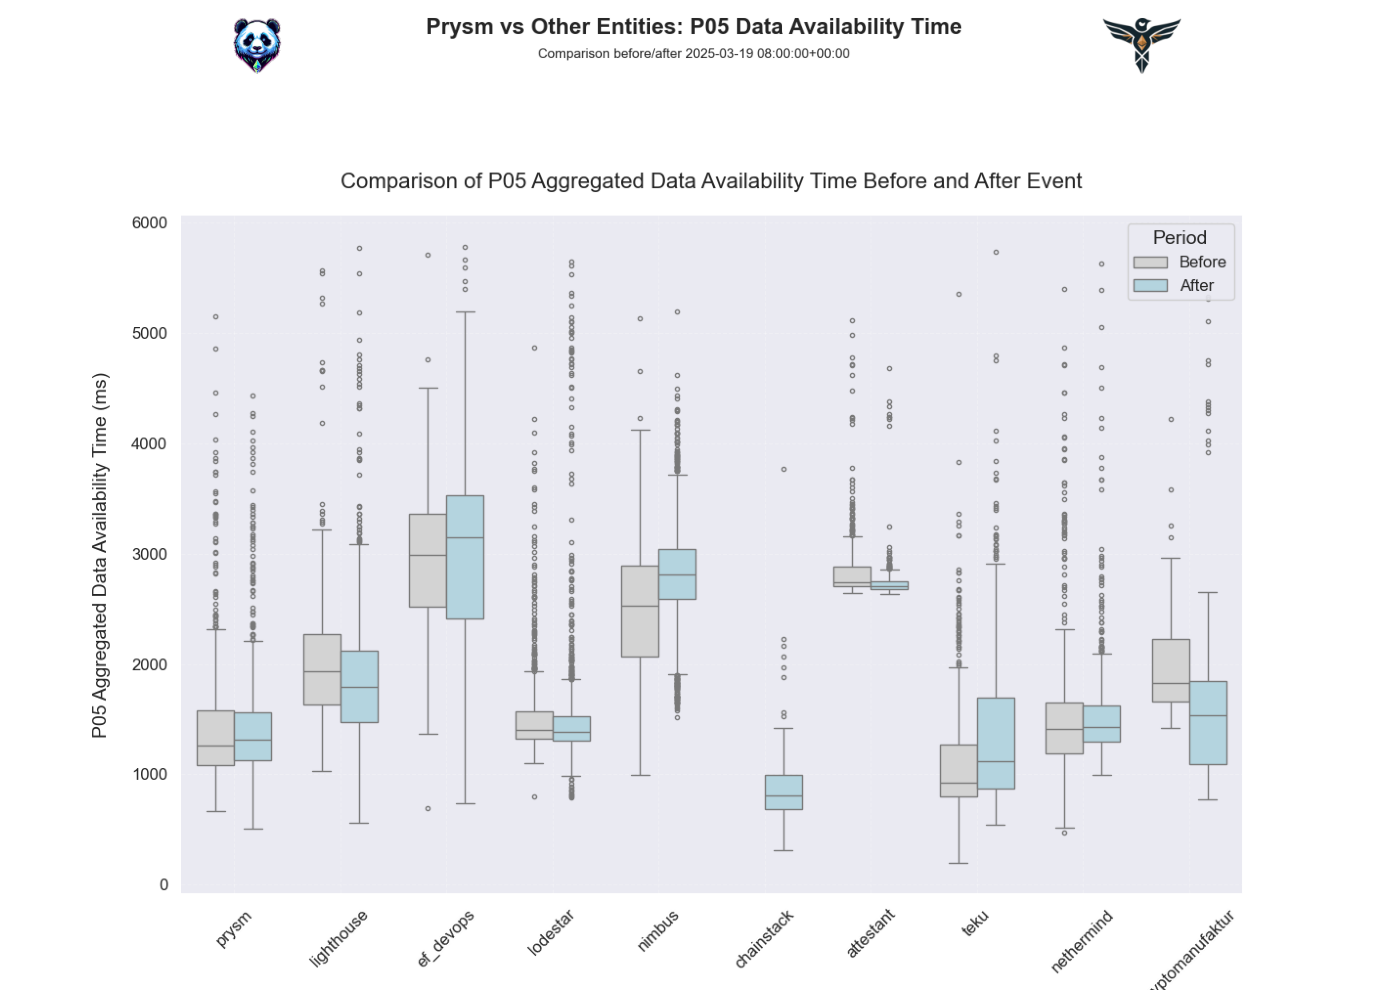

In [68]:
# Compare Prysm performance against other entities for data availability time metrics

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter

def compare_prysm_performance(metric, other_entities, title=""):
    """
    Creates a boxplot comparing Prysm's performance against other entities for a specific metric
    before and after the event date.
    
    Args:
        metric (str): The metric to compare
        other_entities (list): List of other entity names to compare against Prysm
        title (str): Title for the plot
    
    Returns:
        matplotlib.pyplot: The plot object
    """
    # Create figure with a single boxplot
    fig, ax = plt.subplots(figsize=(14, 9))
    
    # Convert event_date to timestamp for comparison
    event_timestamp = pd.Timestamp(event_date).timestamp()
    
    # Prepare data for Prysm
    prysm_data = prepare_entity_data("prysm")
    if prysm_data is None:
        return plt
    
    # Convert the time column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(prysm_data['time']):
        prysm_data['time'] = pd.to_datetime(prysm_data['time'])
    
    # Add timestamp column for easier comparison
    prysm_data['timestamp'] = prysm_data['time'].astype(int) // 10**9
    
    # Filter data before and after the event for Prysm
    prysm_before = prysm_data[prysm_data['timestamp'] < event_timestamp]
    prysm_after = prysm_data[prysm_data['timestamp'] >= event_timestamp]
    
    # Prepare data for comparison
    comparison_data = []

    # Add Prysm data to comparison
    if not prysm_before.empty:
        prysm_before_df = pd.DataFrame({
            'value': prysm_before[metric].dropna(),
            'period': 'Before',
            'entity': 'prysm'
        })
        comparison_data.append(prysm_before_df)
    
    if not prysm_after.empty:
        prysm_after_df = pd.DataFrame({
            'value': prysm_after[metric].dropna(),
            'period': 'After',
            'entity': 'prysm'
        })
        comparison_data.append(prysm_after_df)
    
    # Add other entities data to comparison
    for entity in other_entities:
        entity_data = prepare_entity_data(entity)
        if entity_data is None:
            continue
            
        # Convert the time column to datetime if it's not already
        if not pd.api.types.is_datetime64_any_dtype(entity_data['time']):
            entity_data['time'] = pd.to_datetime(entity_data['time'])
        
        # Add timestamp column for easier comparison
        entity_data['timestamp'] = entity_data['time'].astype(int) // 10**9
        
        # Filter data before and after the event
        entity_before = entity_data[entity_data['timestamp'] < event_timestamp]
        entity_after = entity_data[entity_data['timestamp'] >= event_timestamp]
        
        if not entity_before.empty:
            entity_before_df = pd.DataFrame({
                'value': entity_before[metric].dropna(),
                'period': 'Before',
                'entity': entity
            })
            comparison_data.append(entity_before_df)
        
        if not entity_after.empty:
            entity_after_df = pd.DataFrame({
                'value': entity_after[metric].dropna(),
                'period': 'After',
                'entity': entity
            })
            comparison_data.append(entity_after_df)
    
    # Combine all data
    all_data = pd.concat(comparison_data, ignore_index=True)
    
    # Create boxplot with more spacing
    sns.boxplot(
        x='entity', 
        y='value', 
        hue='period', 
        data=all_data,
        ax=ax,
        palette={'Before': 'lightgray', 'After': 'lightblue'},
        width=0.7,  # Adjust width for more spacing
        fliersize=3  # Smaller outlier points
    )
    
    # Improve plot appearance
    ax.set_title(f'Comparison of {metric.replace("_", " ").title()} Before and After Event', fontsize=16, pad=20)
    ax.set_xlabel('Entity', fontsize=14, labelpad=15)
    ax.set_ylabel(f'{metric.replace("_", " ").title()} (ms)', fontsize=14, labelpad=15)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.tick_params(axis='x', labelrotation=45, labelsize=12, pad=10)
    ax.tick_params(axis='y', labelsize=12, pad=10)
    
    # Improve legend
    legend = ax.legend(title='Period', fontsize=12, title_fontsize=14, loc='upper right', frameon=True)
    legend.get_frame().set_alpha(0.9)
    
    # Add branding
    if not title:
        title = f"Prysm vs Other Entities: {metric.replace('_', ' ').title()}"
    
    add_branding(fig, title=title, subtitle=f"Comparison before/after {event_date}")
    
    # Adjust layout with more spacing
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.15, left=0.1, right=0.95)
    
    return plt

entities = ["lighthouse", "ef_devops", "lodestar", "nimbus", "chainstack", "attestant", "teku", "nethermind", "cryptomanufaktur"]
# Compare Prysm's performance against other entities for p05_aggregated_data_availability_time
plot = compare_prysm_performance(
    metric="p05_aggregated_data_availability_time",
    other_entities=entities,
    title="Prysm vs Other Entities: P05 Data Availability Time"
)
plot

plot = compare_prysm_performance(
    metric="p95_aggregated_data_availability_time",
    other_entities=entities,
    title="Prysm vs Other Entities: P95 Data Availability Time"
)
plot
